# This script contains the fundamental algorithm for PMI calculation and the processing pipeline including the PMI matrix visualization,graph construction and analysis and statistical test on these properties.
# Contents
## PMI functions and visualization functions
## application on RJ_iMC paradigm
### single epoch analysis
adjcant matrix, adj_m threshold to reveal important connections, and the graph visualization. Graph properties are bonuses. Some thoughts: the degree measure is not applicable when it comes to connected graph.

Please note that the colorbar will change according to the given adj_matrix. Be careful when comparing two epochs graph.

LOOP function is not provided as it is a exploring step.

### single session (multiple epochs) analysis
Having assess of multiple epochs give us a way to find significant connections via one-sampled t test. It remains a question whether or not we see all chs homogeneous. Although PMI is a ch-blind method, but the nature of EEG-EMG connections are different. So two methods are developped and compared.
Histogram of wienne index for epochs.

### graph analysis: similarity measure can be applied after a sub-graph is created

### Implementation: graph features and z-score analysis

### TMS effect: subj4/10 s02 vs subj4/10 s01
- mixed model: variables (circularity) - group effect (healthy, stroke) - ST-TMS effect (preTMS,postTMS)
- pre-post diff - TMS effect (sham/TMS)
- Linear model (corr): variables - rehabilitation duration/stroke scale

- random surrogate (test)
- save variables


## S1: (S)PMI functions

In [66]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and 
its different variations.'''
# original work: srk-srinivasan
# extension Gansheng_Tan
import itertools
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def s_entropy_withP(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    n_zeros = np.count_nonzero(freq_list==0)
    sh_entropy = n_zeros/len(freq_list)
    freq_list = [element for element in freq_list if element != 0]
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def p_entropy_withP(op):
    ''' Different from P_entropy: the max_entropy is calculated using the len(non_zero(op))
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    # op: ordinal pattern
#     ordinal_pat_nonzero = [element for element in op if element != 0]
#     max_entropy = np.log(len(ordinal_pat_nonzero))
#     p = np.divide(np.array(ordinal_pat_nonzero), float(sum(ordinal_pat_nonzero)))
#     return(s_entropy(p)/max_entropy)
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy_withP(p)/max_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    lst = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_permutations):
        for i in range(len(possible_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)

def p_entropy(op):
    # op: ordinal pattern
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    # take care of the variance within a observed pattern
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    temp_list = list()
    wop = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        Xi = time_series[i:(embdim+i)]
        Xn = time_series[(i+embdim-1): (i+embdim+embdim-1)]
        Xi_mean = np.mean(Xi)
        Xi_var = (Xi-Xi_mean)**2
        weight = np.mean(Xi_var)
        sorted_index_array = list(np.argsort(Xi))
        temp_list.append([''.join(map(str, sorted_index_array)), weight])
    result = pd.DataFrame(temp_list,columns=['pattern','weights'])
    freqlst = dict(result['pattern'].value_counts())
    for pat in (result['pattern'].unique()):
        wop.append(np.sum(result.loc[result['pattern']==pat,'weights'].values))
    return(wop)

def joint_ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of two time series for a given embedding dimension and embedding delay.
    USAGE: joint_ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing two time series ,shape =(2,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series_x = ts[0]
    time_series_y = ts[1]
    possible_permutations = list(itertools.permutations(range(embdim)))
    possible_permutations_repeat = np.repeat(np.array(list(itertools.permutations(range(embdim)))),6,axis=0)
    possible_permutations_interlace = np.array(list(itertools.permutations(range(embdim)))*6)
    possible_joint_permutations = np.concatenate((possible_permutations_repeat,possible_permutations_interlace),axis=1)
    lst_x = list()
    lst_y = list()
    lst = list()
    for i in range(len(time_series_x) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series_x[i:(embdim+i)]))
        lst_x.append(sorted_index_array)
        sorted_index_array = list(np.argsort(time_series_y[i:(embdim+i)]))
        lst_y.append(sorted_index_array)
    lst_x = np.array(lst_x)
    lst_y = np.array(lst_y)
    lst = np.concatenate ((lst_x,lst_y),axis=1)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_joint_permutations):
        for i in range(len(possible_joint_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)
    
def PMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)

def PMI_2chs_withP(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy_withP(op_x)
    p_y = p_entropy_withP(op_y)
    p_xy = p_entropy_withP(op_xy)
    return (p_x+p_y-p_xy)

def PMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            PMI[i,j] = (p_x+p_y-p_xy)
    return PMI

def PMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the PMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    PMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                PMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)
    return PMI

def SPMI_2chs(ts_2chs,embdim, embdelay):
    op_x = ordinal_patterns(ts_2chs[0],embdim,embdelay)
    op_y = ordinal_patterns(ts_2chs[1],embdim,embdelay)
    op_xy = joint_ordinal_patterns(ts_2chs,embdim,embdelay)
    p_x = p_entropy(op_x)
    p_y = p_entropy(op_y)
    p_xy = p_entropy(op_xy)
    return (p_x+p_y-p_xy)/p_xy

def SPMI_1epoch(epoch,embdim,embdelay):
    ''' This function computes the SPMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epoch = Numpy arrayshape =(n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    SPMI = np.zeros([epoch.shape[0],epoch.shape[0]])
    for i in range(epoch.shape[0]):
        for j in np.arange(i,epoch.shape[0]):
            op_x = ordinal_patterns(epoch[i],embdim,embdelay)
            op_y = ordinal_patterns(epoch[j],embdim,embdelay)
            op_xy = joint_ordinal_patterns(np.array([epoch[i],epoch[j]]),embdim,embdelay)
            p_x = p_entropy_withP(op_x)
            p_y = p_entropy_withP(op_y)
            p_xy = p_entropy_withP(op_xy)
            SPMI[i,j] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def SPMI_epochs(epochs,embdim,embdelay):
    ''' This function computes the SPMI for an epoch.
    USAGE: PMI_1epoch(epoch, embdim, embdelay)
    ARGS: epochs = Numpy arrayshape =(n_epochs,n_channels,ts), 
    embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: PMI matrix
    '''
    SPMI = np.zeros([epochs.shape[0],epochs.shape[1],epochs.shape[1]])
    for epoch_idx in range(epochs.shape[0]):
        for ch1_idx in range(epochs.shape[1]):
            for ch2_idx in np.arange(ch1_idx,epochs.shape[1]):
                op_x = ordinal_patterns(epochs[epoch_idx][ch1_idx],embdim,embdelay)
                op_y = ordinal_patterns(epochs[epoch_idx][ch2_idx],embdim,embdelay)
                op_xy = joint_ordinal_patterns(np.array([epochs[epoch_idx][ch1_idx],epochs[epoch_idx][ch2_idx]]),
                                               embdim,embdelay)
                p_x = p_entropy_withP(op_x)
                p_y = p_entropy_withP(op_y)
                p_xy = p_entropy_withP(op_xy)
                SPMI[epoch_idx,ch1_idx,ch2_idx] = (p_x+p_y-p_xy)/p_xy
    return SPMI

def get_ch_name(epochs,ch_idx,emg_map=None):
    '''
    This function works when the number of EEG electrode is 32.
    if the emg mapping was given, the function return the muscle related to the emg electrod. 
    '''
    if ch_idx<32:
        return (epochs.info['ch_names'][ch_idx])
    elif ch_idx<40:
        if emg_map == None:
            return ('emg'+str(ch_idx-31))
        else:
            return emg_map['emg'+str(ch_idx-31)]
    else:
        return 0

def is_symmetric(a,tol = 1e-3):
    return (np.abs(a - a.T) <= tol).all()    
    
def chs_remap(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == False:
        cons =  cons + cons.T - np.diag(np.diag(cons))
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped

def chs_remap4directionalCons(cons,chs_list,pareticSide):
    '''
    This function is designed for hemisphere normalization for stroke patients. It remaps EEG electrodes into chs of 
    ipsilateral hemisphere and contralateral hemisphere
    
    Fpz,AFz,Fz,FCz,Cz,CPz,Pz,POz,Oz remains unmapped
    
    the cons is supposed to be a n * n matrix (symmetric or not), if cons is not symmetric, only the upper triangle is
    taken into account
    chs_list is passed by epochs_hybrid.info['ch_names']
    pareticSide can be only 'l' or 'r'
    '''
    if is_symmetric(cons) == True:
        print("please make sure that the connectivity measure is directional")
    chs_map_lParetic = {'Fp1':'Fp1i','AF3':'AF3i','F3':'F3i','F7':'F7i','FC1':'FC1i','FC5':'FC5i','C3':'C3i',
                        'T7':'T7i','CP1':'CP1i','CP5':'CP5i','P3':'P3i','P7':'P7i','PO3':'PO3i','O1':'O1i',
                       'Fp2':'Fp1c','AF4':'AF3c','F4':'F3c','F8':'F7c','FC2':'FC1c','FC6':'FC5c','C4':'C3c',
                       'T8':'T8c','CP2':'CP1c','CP6':'CP5c','P4':'P3c','P8':'P7c','PO4':'PO3c','O2':'O1c'}
    
    chs_map_rParetic = {'Fp2':'Fp1i','AF4':'AF3i','F4':'F3i','F8':'F7i','FC2':'FC1i','FC6':'FC5i','C4':'C3i',
                        'T8':'T7i','CP2':'CP1i','CP6':'CP5i','P4':'P3i','P8':'P7i','PO4':'PO3i','O2':'O1i',
                       'Fp1':'Fp1c','AF3':'AF3c','F3':'F3c','F7':'F7c','FC1':'FC1c','FC5':'FC5c','C3':'C3c',
                       'T7':'T8c','CP1':'CP1c','CP5':'CP5c','P3':'P3c','P7':'P7c','PO3':'PO3c','O1':'O1c'}
    
    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    
 
    cons_remapped = np.zeros(cons.shape)
    if pareticSide == 'l':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_lParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
    elif pareticSide == 'r':
        for ch1_idx in range(len(chs_list_image)):
            for ch2_idx in range(len(chs_list_image)):
                ch1_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch1_idx])
                ch2_idx_preImage = chs_list.index(chs_list_preImage_rParetic[ch2_idx])
                cons_remapped[ch1_idx,ch2_idx] = cons [ch1_idx_preImage,ch2_idx_preImage]
        
    else:
        print("unknown pareticSide")
    return cons_remapped
       

## S2: Visualization fcs

In [67]:
from itertools import count
import matplotlib,numpy as np
import matplotlib.cm as cm

class EEGChannel:
    '''innitilized by info chs'''
    _ids = count(0)
    
    def __init__(self, x, y,name="None"):
        self.id = next(self._ids)
        self.x = x
        self.y = y
        self.name = name
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax 

    
class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)

# EMG Topograph_basis
def plotTopoEMG(EMGs,ax,center=[7,0]):
    for i in range(2):
        circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
        ax.add_artist(circle)
    for EMG in EMGs:
        ax = EMG.plot(ax,center)
    return ax

def plotTopoEEG(EEGs,ax,center=[-5,0],radius=6):
    circle = plt.Circle((center[0],center[1]),radius,fill = False)
    ax.plot()
    ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.add_artist(circle)
    for EEG in EEGs:
        ax = EEG.plot(ax,center)
    return ax    
    
def c_map(data):
    '''
    data should be numpy array (adj_m, for example)
    '''
    minima = np.min(data[np.nonzero(data)])
    maxima = np.max(data)
    if minima==maxima:
        minima-=0.2
        maxima+=0.2
    norm = matplotlib.colors.Normalize(vmin=minima,vmax=maxima,clip=True)
#     mapper = cm.ScalarMappable(norm=norm,cmap=cm.viridis)
    mapper = cm.ScalarMappable(norm=norm,cmap="YlGnBu")
    return mapper

def graph_plot(adj_m,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    mapper = c_map(adj_m)
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax



# single epoch analysis
## step 0: dataset loading and hemisphere normalization

In [68]:
########## Import ##############
import os,numpy as np, pandas as pd,mne
################################

################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '10'
contraction_type = 'iMC'
session_idx = 's02'

subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]

results_dir = os.path.join(data_dir,'subj'+subj_idx,'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Dir in PC
# data_dir = 'E:/important file/Projects/CM-graph/sample_data/'
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)
#####################################################################

Reading D:/Data/MultiEEGEMG_stroke/subj10\epochs_hybrid\subj10_iMC_s02_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
33 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## step 1: SPMI calculation
### the graph will not include diagonal info 

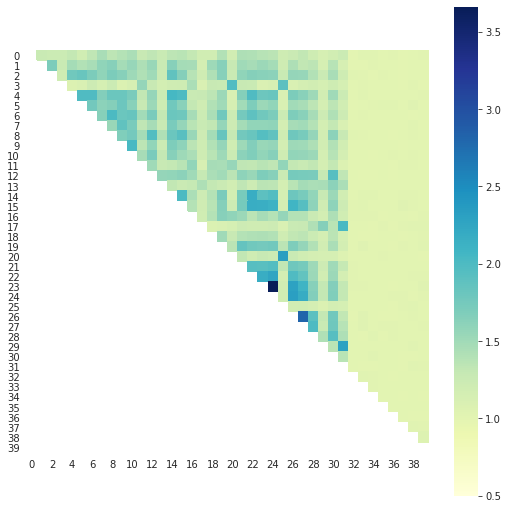

In [69]:
# calculate one epoch_be4 TMS
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
#########################

########## Customization ##########
epoch_idx = 4 #change this parameter to analysis epoch
embdim = 3
embdelay = 1
singleEpochSPMI_matrix_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m.eps')

###################################
# epoch = df_hybrid[df_hybrid['epoch']==0].to_numpy()[:,3:].T
epoch_data = epochs_hybrid.get_data()[epoch_idx]
SPMI = SPMI_1epoch(epoch_data,embdim,embdelay)

###### hemisphere remap - turning SPMI into symmetric
SPMI = chs_remap(SPMI,epochs_hybrid.info['ch_names'],affected_h)
SPMI_withoutD = SPMI - np.diag(np.diag(SPMI))
mask = np.zeros_like(SPMI_withoutD)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD, mask=mask,vmin =.5, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_fName)

## step 2.1: thresholding - percentile - ignored
Note: (S)PMI is already symmetric

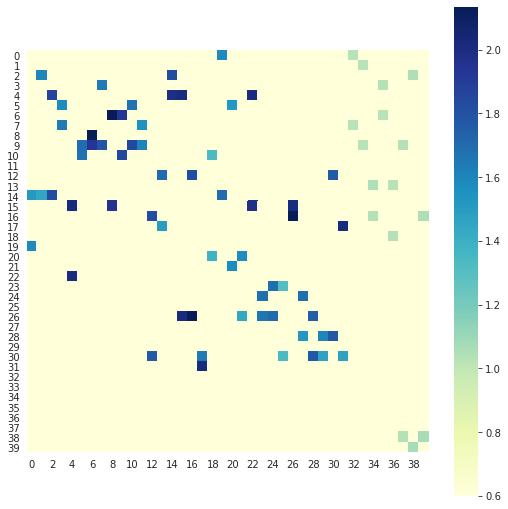

In [111]:
############### parameters ##########
percentile = 95
singleEpochSPMI_thm_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_thm.eps')
#####################################
# if is_symmetric(SPMI)==False:
#     SPMI_symmetric = SPMI+SPMI.T-2*np.diag(np.diag(PMI))
# else:
#     SPMI_symmetric = SPMI-np.diag(np.diag(PMI))
SPMI_symmetric = SPMI_withoutD.copy()
SPMI_symmetric_th = np.resize(np.percentile(SPMI_symmetric,95,axis=0),SPMI_symmetric.shape)
SPMI_symmetric[SPMI_symmetric<=SPMI_symmetric_th]=0
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_symmetric,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_thm_fName)


## Step 2.2: surrogate testing - shuffle surrogate - ignored

In [ ]:
import os
from numpy import random
##### Parameters
singleEpochSPMI_matrix_ssrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m_ssrg.eps')
step = 50
num_srg = 20
epoch_duration_sample = 1001
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
#################
# load baseline raw
raw_srg_dir = os.path.join(data_dir,'subj'+subj_idx,'raw_srg')
raw_srg_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_raw.fif')
raw_srg = mne.io.read_raw_fif(raw_srg_fName)
shuffle = random.shuffle
SPMI_epoch_srg_dstbt = []
SPMI_ssrg = SPMI_withoutD.copy()
SPMI_ssrg = np.triu(SPMI_ssrg)
for i in range(num_srg):
    epoch_data_srg = epoch_data.copy()
    for i in range(epoch_data_srg.shape[0]):
        shuffle(epoch_data_srg[i,:])
    SPMI_epoch_srg = chs_remap(SPMI_1epoch(epoch_data_srg,embdim,embdelay),
                                      epochs_hybrid.info['ch_names'],affected_h) #diag is maximal due to the nature of SPMI
    SPMI_epoch_srg_withoutD = SPMI_epoch_srg-np.diag(np.diag(SPMI_epoch_srg))
    SPMI_epoch_srg_dstbt.append(SPMI_epoch_srg_withoutD)
for ch1_idx in range(SPMI_withoutD.shape[0]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[0]):
        if (np.percentile(np.array(SPMI_epoch_srg_dstbt)[:,ch1_idx,
                                               ch2_idx],1)<SPMI_ssrg[ch1_idx,
                                               ch2_idx]<np.percentile(np.array(SPMI_epoch_srg_dstbt)[:,ch1_idx,
                                                                                                       ch2_idx],99)):
            SPMI_ssrg[ch1_idx,ch2_idx]=0
        else:
            pass
mask = np.zeros_like(SPMI_ssrg)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_ssrg, mask=mask,vmin =.5, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_ssrg_fName)


Opening raw data file D:/Data/MultiEEGEMG_stroke/subj10\raw_srg\subj10_iMC_s02_srg_raw.fif...
    Range : 2351 ... 11351 =      4.702 ...    22.702 secs
Ready.


## Step 2.3* surrogate testing - surrogate generation 

In [ ]:
import os
##### Parameters
step = 50
num_srg = 100
epoch_duration_sample = 1001
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
#################
# load baseline raw
raw_srg_dir = os.path.join(data_dir,'subj'+subj_idx,'raw_srg')
raw_srg_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_raw.fif')
raw_srg = mne.io.read_raw_fif(raw_srg_fName)

SPMI_bsrg_dstbts = np.zeros((SPMI_withoutD.shape[0],SPMI_withoutD.shape[0],num_srg))
for ch1_idx in range(SPMI_withoutD.shape[0]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[0]):
        SPMI_srg_dstbt_2chs = []
        if affected_h == 'l':
            ch2_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[ch2_idx])
            ch1_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[ch1_idx])
        elif affected_h == 'r':
            ch2_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[ch2_idx])
            ch1_idx_preImage = epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[ch1_idx])
        else:
             print('unknown EEG ch')
        for i in range(num_srg):
            ch1_srg_data = raw_srg.get_data()[ch1_idx_preImage][i*step:epoch_duration_sample+i*step]
            ch2_srg_data = raw_srg.get_data()[ch2_idx_preImage][i*step:epoch_duration_sample+i*step]
            SPMI_srg_dstbt_2chs.append(SPMI_2chs([ch1_srg_data,ch2_srg_data],embdim,embdelay))
        SPMI_bsrg_dstbts[ch1_idx][ch2_idx] = SPMI_srg_dstbt_2chs

## Step 2.3**: save surrogate data and reload

In [ ]:
# Save script
import numpy as np
from numpy import savetxt
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_bsrg_dstbts_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI_dstbts.txt')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
with open(SPMI_bsrg_dstbts_fName, 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(SPMI_bsrg_dstbts.shape))
    for data_slice in SPMI_bsrg_dstbts:
        np.savetxt(outfile, data_slice, fmt='%-7.4f')
        outfile.write('# New slice\n')

## LOADING script
# Read the array from disk
# n_chs=40
# temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
# SPMI_bsrg_dstbts_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI_dstbts.txt')

# SPMI_bsrg_dstbts = np.loadtxt(SPMI_bsrg_dstbts_fName)
# n_surrogate = SPMI_bsrg_dstbts.shape[0]*SPMI_bsrg_dstbts.shape[1]/n_chs/n_chs
# SPMI_bsrg_dstbts = SPMI_bsrg_dstbts.reshape((n_chs,n_chs,int(n_surrogate)))

## Step 2.3: surrogate testing - baseline surrogate - higher than bsg
### This step aims to test the significant connectivity in iMC phase

In [ ]:
singleEpochSPMI_matrix_hbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m_hbsrg.eps')

SPMI_hbsrg = SPMI_withoutD.copy()
SPMI_hbsrg = np.triu(SPMI_hbsrg)
for ch1_idx in range(SPMI_withoutD.shape[0]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[0]):
        if (SPMI_hbsrg[ch1_idx,ch2_idx]<np.percentile(SPMI_bsrg_dstbts[ch1_idx,ch2_idx],99)):
            SPMI_hbsrg[ch1_idx,ch2_idx]=0
        else:
            pass
mask = np.zeros_like(SPMI_hbsrg)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_hbsrg, mask=mask,vmin =.5, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_hbsrg_fName)
#####################################################################

## Step 2.4: bsrg, lower than bsrg

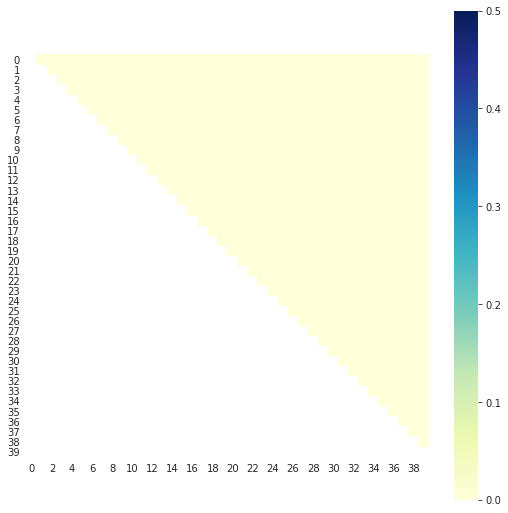

In [65]:
singleEpochSPMI_matrix_lbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_m_lbsrg.eps')
SPMI_lbsrg = SPMI_withoutD.copy()
SPMI_lbsrg = np.triu(SPMI_lbsrg)
for ch1_idx in range(SPMI_withoutD.shape[0]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[0]):
        if (SPMI_lbsrg[ch1_idx,ch2_idx]>np.percentile(SPMI_bsrg_dstbts[ch1_idx,ch2_idx],1)):
            SPMI_lbsrg[ch1_idx,ch2_idx]=0
        else:
            pass
mask = np.zeros_like(SPMI_lbsrg)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_lbsrg, mask=mask,vmin =.5, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(singleEpochSPMI_matrix_lbsrg_fName)
#####################################################################

## Step 3.1: graph analysis (percentile threshold) - ipsilateral is always on the left - ignored

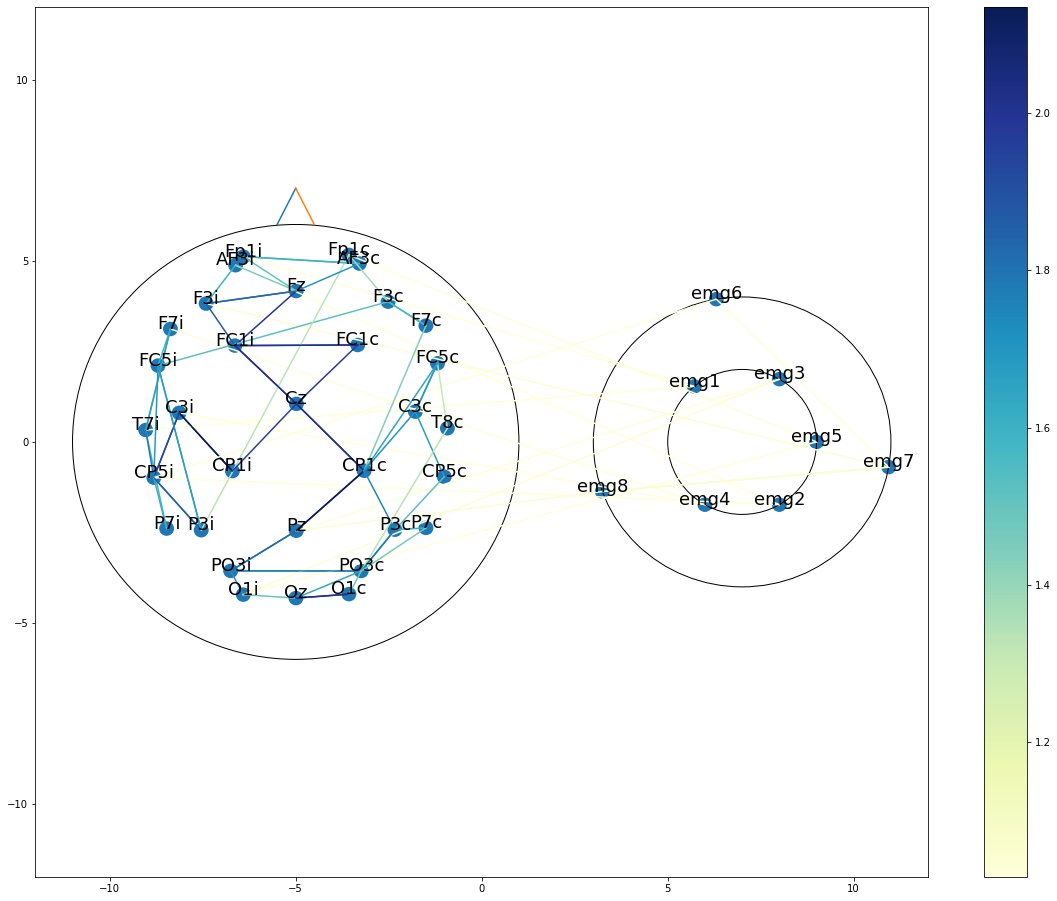

In [114]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

# if affected_h == 'l':
EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 
# elif affected_h == 'r':
#     EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
#                    y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
#                    name=ch) for ch in chs_list_image] 
# else:
#      print('unknown EEGs')

singleEpochSPMI_g_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_symmetric,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_fName)


## Step 3.2: graph analysis (shuffle surrogate) - ipsilateral is always on the left - ignored

<Figure size 432x288 with 0 Axes>

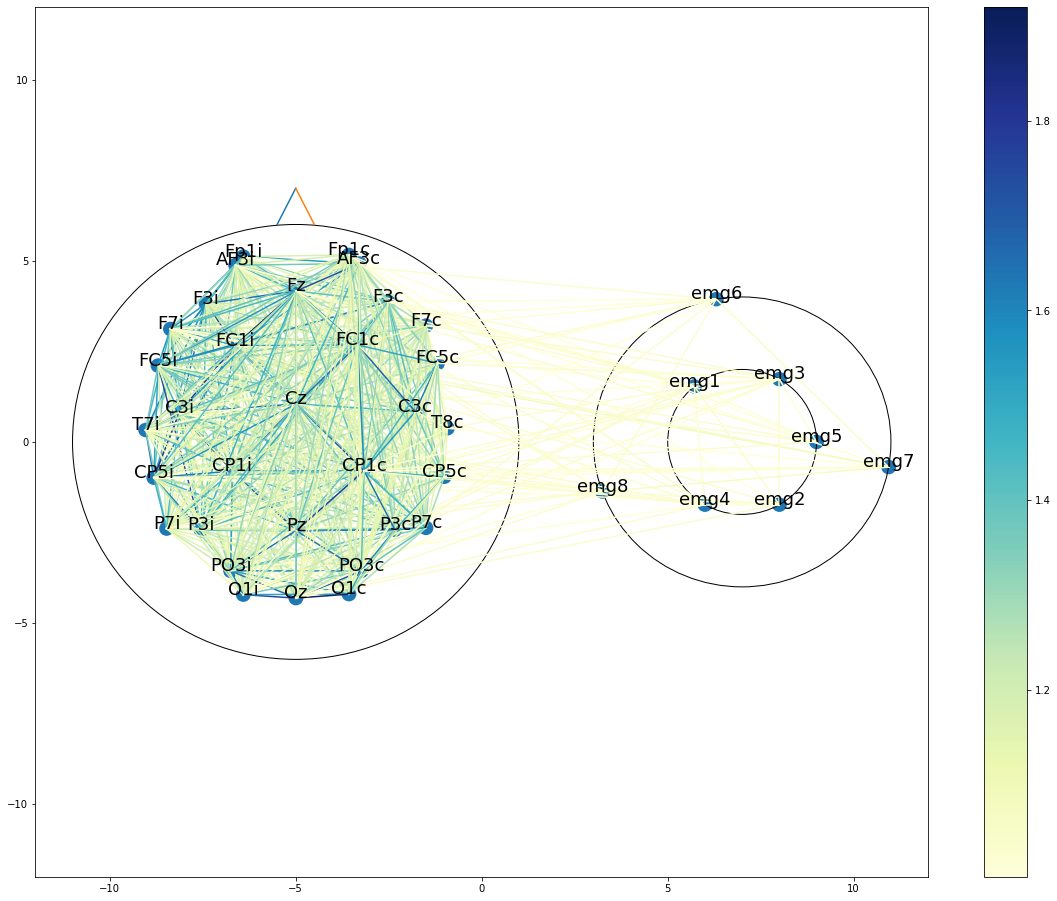

In [97]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

# if affected_h == 'l':
EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 
# elif affected_h == 'r':
#     EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
#                    y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
#                    name=ch) for ch in chs_list_image] 
# else:
#      print('unknown EEGs')

singleEpochSPMI_g_ssrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g_ssrg.eps')
#########################################


plt.clf()
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_ssrg,fig,ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_ssrg_fName)


## Step 3.3: graph analysis (higher than bsrg)

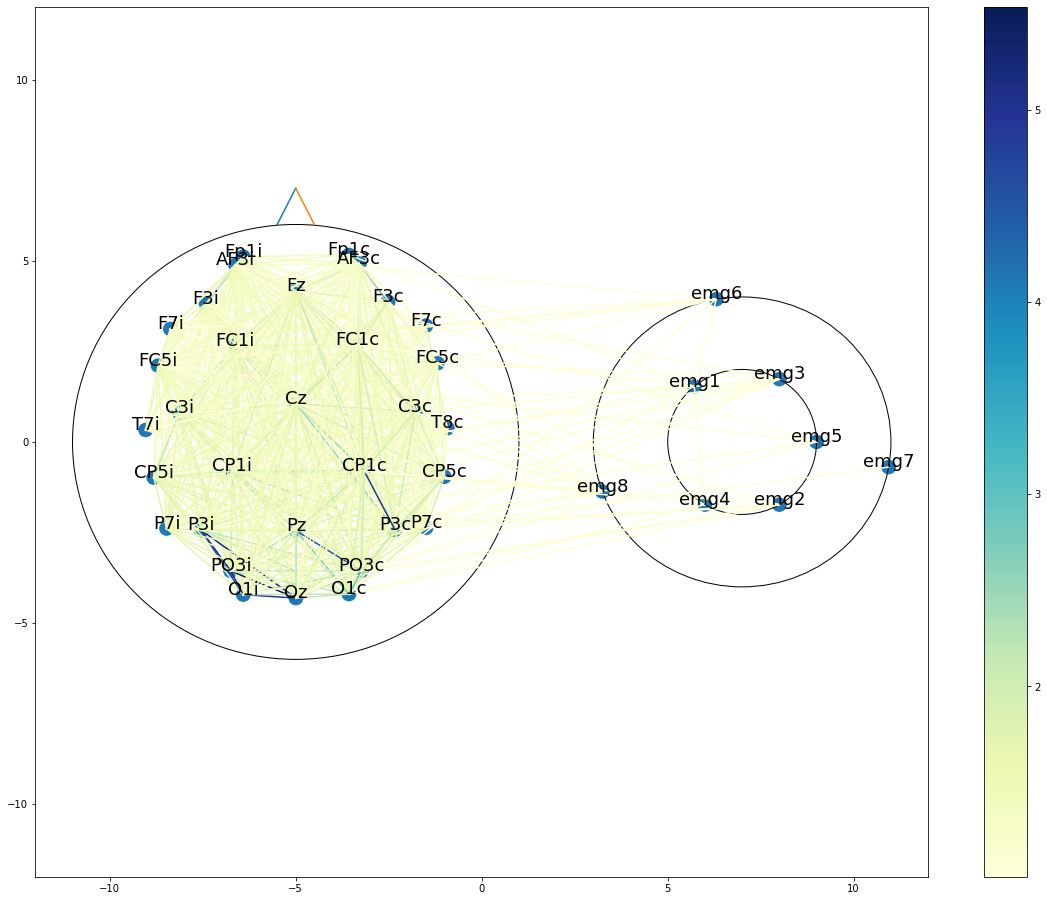

In [30]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

# if affected_h == 'l':
EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

singleEpochSPMI_g_hbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g_hbsrg.eps')
#########################################
fig.clf()
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_hbsrg,fig,ax)


plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_hbsrg_fName)


## Step 3.4: graph analysis (lower than bsrg)

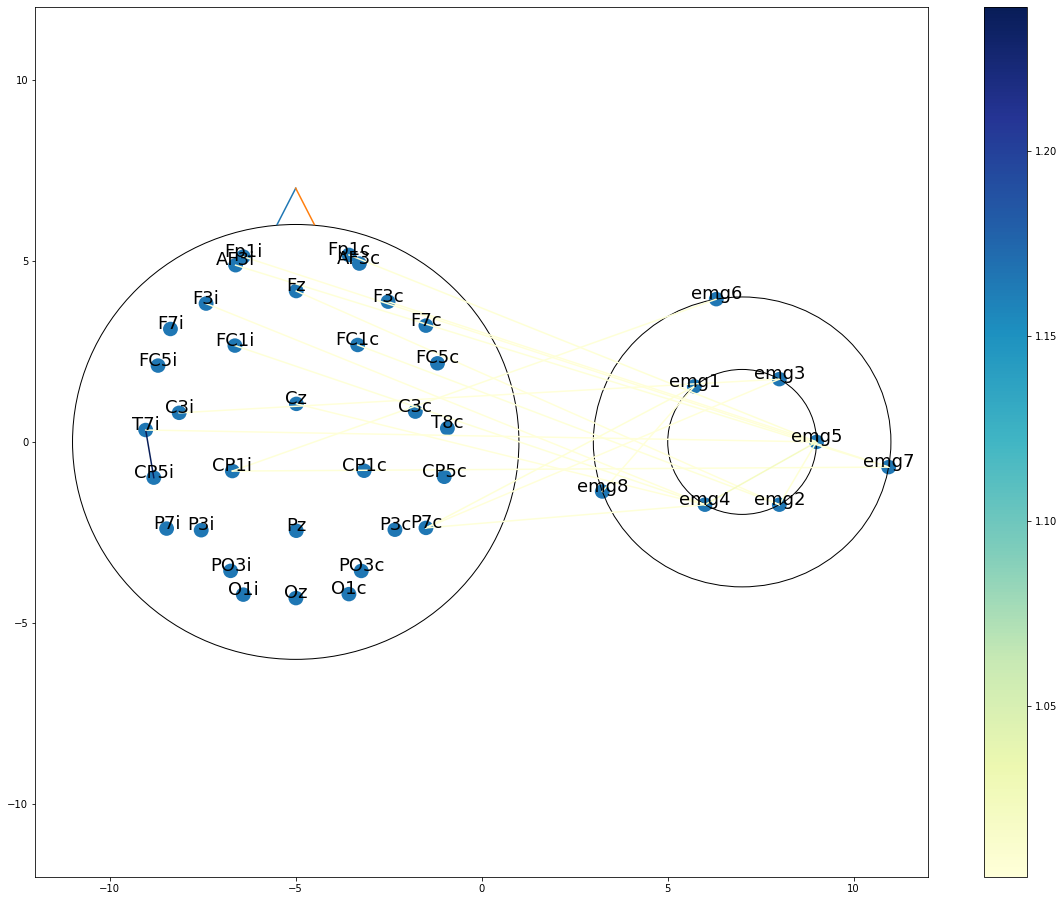

In [31]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

# if affected_h == 'l':
EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

singleEpochSPMI_g_lbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epoch'+str(epoch_idx)+'_SPMI_g_lbsrg.eps')
#########################################
fig.clf()
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_lbsrg,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(singleEpochSPMI_g_lbsrg_fName)


## graph properties (wierner_index) for complete graph - ignored

In [49]:
# import networkx as nx
# PMI_symmetric = PMI+PMI.T-2*np.diag(np.diag(PMI))
# G = nx.convert_matrix.from_numpy_matrix(PMI_symmetric)
# nx.algorithms.wiener.wiener_index(G,'weight')
# # G.size('weight')
# PMI_symmetric.sum()

1628.572708102706

# Multiple epochs (single session) analysis
## step 0: dataset loading

In [33]:
########## Import ##############
import os,numpy as np, pandas as pd,mne
################################

################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '2'
contraction_type = 'iMC'
session_idx = 's01'

subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]

results_dir = os.path.join(data_dir,'subj'+subj_idx,'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Dir in PC
# data_dir = 'E:/important file/Projects/CM-graph/sample_data/'
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)
#####################################################################

## LOADING script
# Read the bsrg data from disk
n_chs=40
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_bsrg_dstbts_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI_dstbts.txt')

SPMI_bsrg_dstbts = np.loadtxt(SPMI_bsrg_dstbts_fName)
n_surrogate = SPMI_bsrg_dstbts.shape[0]*SPMI_bsrg_dstbts.shape[1]/n_chs/n_chs
SPMI_bsrg_dstbts = SPMI_bsrg_dstbts.reshape((n_chs,n_chs,int(n_surrogate)))

Reading D:/Data/MultiEEGEMG_stroke/subj2\epochs_hybrid\subj2_iMC_s01_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## step 1: SPMI calculation

In [34]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#########################

########## Customization ##########
alpha = 0.05
embdim = 3
embdelay = 1
# ho stands for homogeneous

###################################
# epoch = df_hybrid[df_hybrid['epoch']==0].to_numpy()[:,3:].T
epoch_data = epochs_hybrid.get_data()
SPMI = SPMI_epochs(epoch_data,embdim,embdelay)

for SPMI_idx in range(SPMI.shape[0]):
    SPMI[SPMI_idx] = chs_remap(SPMI[SPMI_idx],epochs_hybrid.info['ch_names'],affected_h)

SPMI_withoutD = SPMI.copy()
for SPMI_idx in range(SPMI_withoutD.shape[0]):
    SPMI_withoutD[SPMI_idx] = SPMI_withoutD[SPMI_idx] - np.diag(np.diag(SPMI_withoutD[SPMI_idx]))
SPMI_withoutD_overall_m = np.sum(SPMI_withoutD)/np.count_nonzero(SPMI_withoutD)

## step 1.5: SPMI saving and reloading

In [35]:
# SAVING script
import numpy as np
from numpy import savetxt
temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
SPMI_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI.txt')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
with open(SPMI_fName, 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(SPMI_withoutD.shape))
    for data_slice in SPMI_withoutD:
        np.savetxt(outfile, data_slice, fmt='%-7.4f')
        outfile.write('# New slice\n')

## LOADING script
## Read the array from disk
# import os
# n_chs = 40
# temp_dir = os.path.join(data_dir,'subj'+subj_idx,'temp')
# SPMI_fName = os.path.join(temp_dir,contraction_type+'_'+session_idx+'_SPMI.txt')

# SPMI_withoutD = np.loadtxt(SPMI_fName)
# n_epochs = SPMI_withoutD.shape[0]*SPMI_withoutD.shape[1]/n_chs/n_chs
# SPMI_withoutD = SPMI_withoutD.reshape((int(n_epochs),n_chs,n_chs))

## step 2.1: matrix visualization - homogeneous chs - ignored

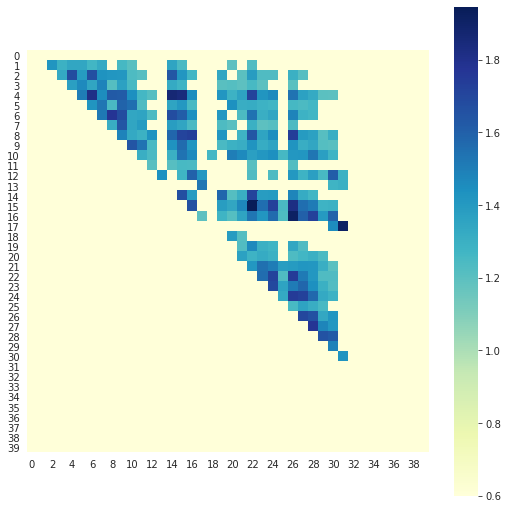

In [106]:
epochsSPMI_matrix_ho_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_ho.eps')

t_stats = np.zeros((SPMI.shape[1],SPMI.shape[2]))
p_values = np.zeros((SPMI.shape[1],SPMI.shape[2]))
sig_cons_mask = np.zeros((SPMI.shape[1],SPMI.shape[2]))
for ch1_idx in range(SPMI.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[1]):
        SPMI_2chs = SPMI_withoutD[:,ch1_idx,ch2_idx]
        t_stat,p_value = stats.ttest_1samp(SPMI_2chs,SPMI_withoutD_overall_m)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat > 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            
SPMI_withoutD_m_sig = np.mean(SPMI_withoutD,axis=0) * sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_m_sig,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_ho_fName)

## Step 2.2: graph analysis - visualization - ignored

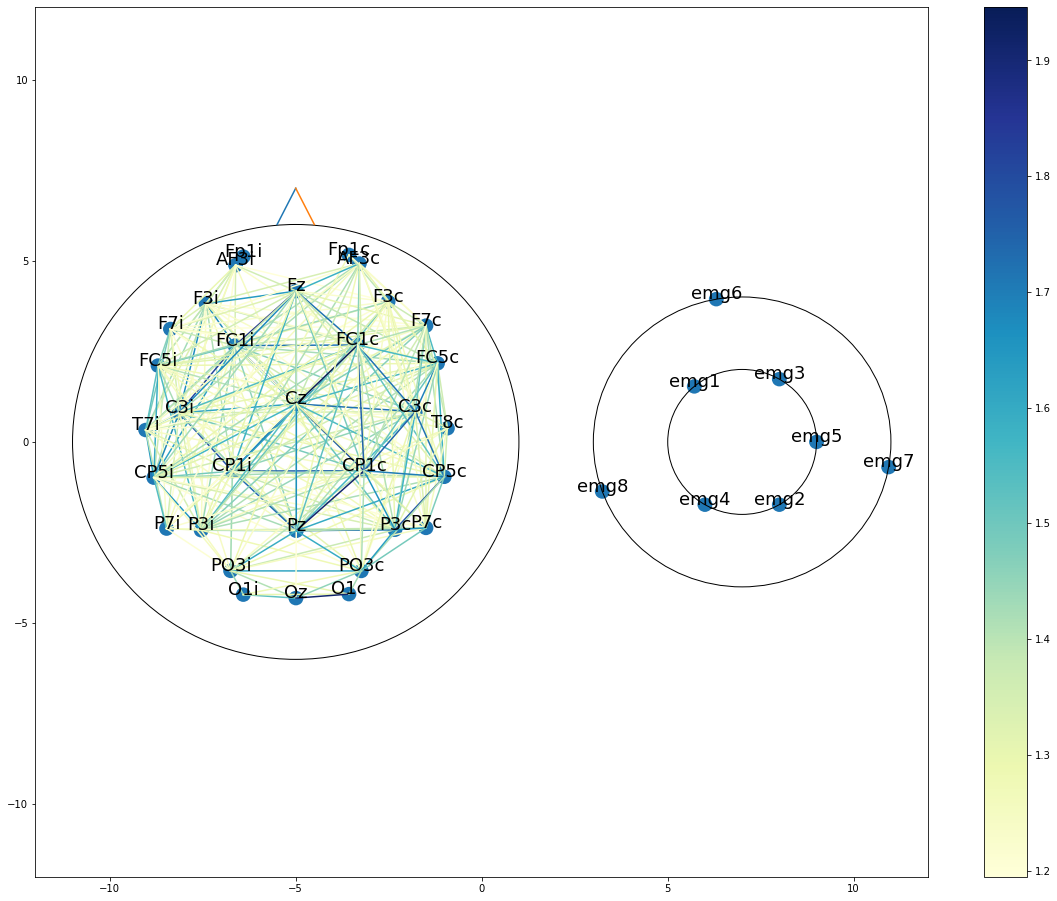

In [107]:
########### customization ###################
EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

epochsSPMI_matrix_ho_g_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_ho_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_withoutD_m_sig,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(epochsSPMI_matrix_ho_g_fName)


## step 3.1: matrix visualization - heterogeneous chs - ignored

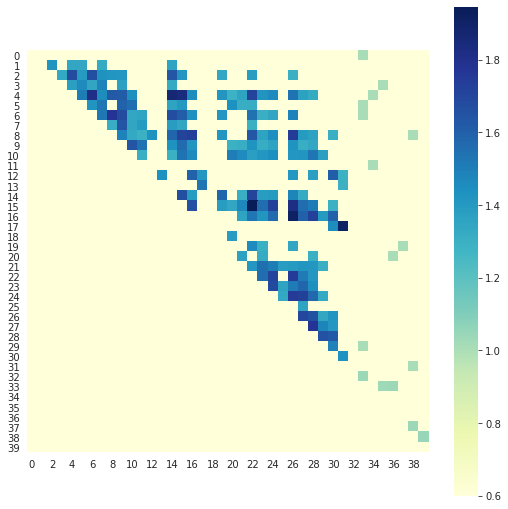

In [108]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#########################

########## Customization ##########
alpha = 0.05
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8
epochsSPMI_matrix_he_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_he.eps')
# he stands for homogeneous


# ch-specific mean
if is_symmetric(SPMI_withoutD[0]):
    SPMI_withoutD_EE_m = np.sum(SPMI_withoutD[:,:n_chs_eeg,:n_chs_eeg])/(np.power(n_chs_eeg,2)-n_chs_eeg)/SPMI_withoutD.shape[0]
    SPMI_withoutD_MM_m = np.sum(SPMI_withoutD[:,n_chs_eeg:,n_chs_eeg:])/(np.power(n_chs_emg,2)-n_chs_emg)/SPMI_withoutD.shape[0]
    SPMI_withoutD_EM_m = np.sum(SPMI_withoutD[:,:n_chs_eeg,n_chs_eeg:])/(n_chs_emg*n_chs_eeg)/SPMI_withoutD.shape[0]
else:
    SPMI_withoutD_EE_m = np.sum(SPMI_withoutD[:,:n_chs_eeg,:n_chs_eeg])/(np.power(n_chs_eeg,2)-n_chs_eeg)*2/SPMI_withoutD.shape[0]
    SPMI_withoutD_MM_m = np.sum(SPMI_withoutD[:,n_chs_eeg:,n_chs_eeg:])/(np.power(n_chs_emg,2)-n_chs_emg)*2/SPMI_withoutD.shape[0]
    SPMI_withoutD_EM_m = np.sum(SPMI_withoutD[:,:n_chs_eeg,n_chs_eeg:])/(n_chs_emg*n_chs_eeg)/SPMI_withoutD.shape[0]

t_stats = np.zeros((SPMI.shape[1],SPMI.shape[2]))
p_values = np.zeros((SPMI.shape[1],SPMI.shape[2]))
sig_cons_mask = np.zeros((SPMI.shape[1],SPMI.shape[2]))
for ch1_idx in range(SPMI.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI.shape[1]):
        SPMI_2chs = SPMI_withoutD[:,ch1_idx,ch2_idx]
        if ch1_idx < 32: #ch1 is EEG
            if ch2_idx <32: # ch2 is EEG
                t_stat,p_value = stats.ttest_1samp(SPMI_2chs,SPMI_withoutD_EE_m)
            else: # ch2 is EMG
                t_stat,p_value = stats.ttest_1samp(SPMI_2chs,SPMI_withoutD_EM_m)
        else: #ch1 is EMG
            t_stat,p_value = stats.ttest_1samp(SPMI_2chs,SPMI_withoutD_MM_m)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat > 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            
SPMI_withoutD_m_sig = np.mean(SPMI_withoutD,axis=0) * sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_m_sig,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_he_fName)

## step 3.2: graph visualization - heterogeneous chs - ignored

In [10]:

########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

epochsSPMI_matrix_he_g_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_he_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(SPMI_withoutD_m_sig,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(epochsSPMI_matrix_he_g_fName)


NameError: name 'results_dir' is not defined

## Step 4.1: z-score matrix transformation

[[ 0.         40.67350638 24.88750226 ...  0.          0.
   0.        ]
 [ 0.          0.         26.86726863 ...  0.          0.
   1.86353087]
 [ 0.          0.          0.         ...  0.          0.
   5.23772952]
 ...
 [ 0.          0.          0.         ...  0.          1.32832874
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


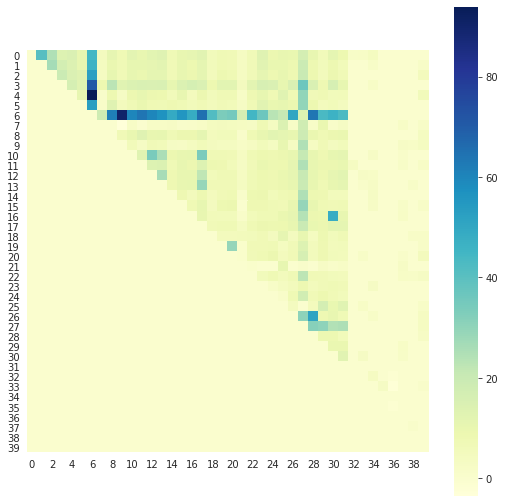

In [61]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
alpha = 1e-5
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8
epochsSPMI_matrix_z_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_zm.eps')
# he stands for homogeneous

t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
SPMI_withoutD_z = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_dstbt = SPMI_withoutD[:,ch1_idx,ch2_idx]
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_ind(SPMI_2chs_dstbt,SPMI_2chs_bsrg_dstbt)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
            SPMI_withoutD_z[ch1_idx][ch2_idx] = (np.mean(SPMI_2chs_dstbt) - np.mean(SPMI_2chs_bsrg_dstbt))/np.std(SPMI_2chs_bsrg_dstbt)
print(SPMI_withoutD_z)
# SPMI_withoutD_4z = np.concatenate((SPMI_bsrg_dstbts,np.expand_dims(np.mean(SPMI_withoutD,axis=0),axis=2)),axis=2)
# SPMI_withoutD_z = stats.zscore(SPMI_withoutD_4z,axis =5)
SPMI_withoutD_z = SPMI_withoutD_z* sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_z, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_z_fName)

## Step 4.1: matrix visualization - higher than bsrg (ind t-test/Wilcoxon-Mann-Whiltney U test)

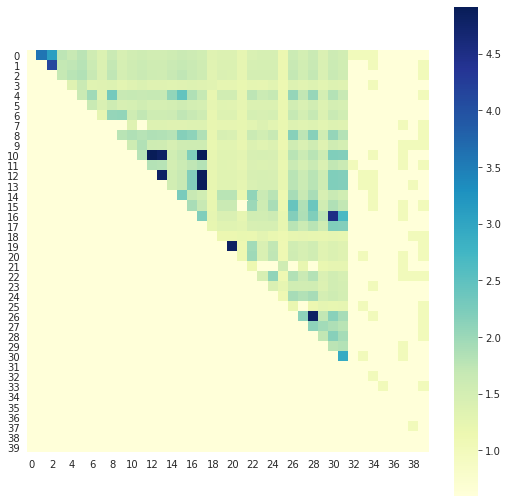

In [36]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
alpha = 1e-5
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8
epochsSPMI_matrix_hbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_hbsrg.eps')
# he stands for homogeneous

t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs_dstbt = SPMI_withoutD[:,ch1_idx,ch2_idx]
        SPMI_2chs_bsrg_dstbt = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_ind(SPMI_2chs_dstbt,SPMI_2chs_bsrg_dstbt)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat > 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
SPMI_withoutD_m_sig = np.mean(SPMI_withoutD,axis=0)* sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_m_sig,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_hbsrg_fName)

## Step 5.1: matrix visualization - lower than bsrg (t-test/Wilcoxon-Mann-Whiltney U test)

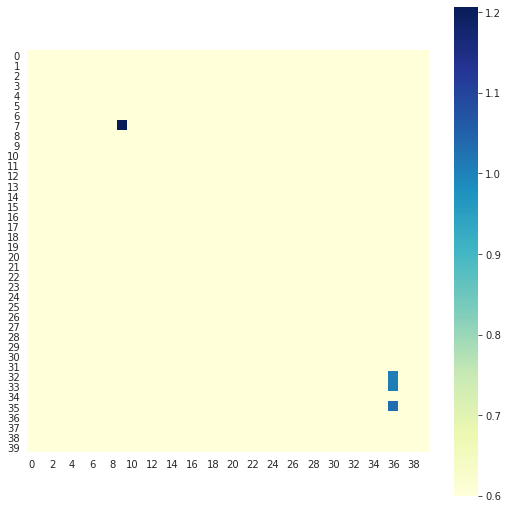

In [37]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ########################distribution check - Normal
# import matplotlib.pyplot as plt
# plt.hist(SPMI_withoutD[:,0,7])
# #############

########## Customization ##########
alpha = 1e-4
embdim = 3
embdelay = 1
n_chs_eeg = 32
n_chs_emg = 8
epochsSPMI_matrix_lbsrg_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_SPMI_m_lbsrg.eps')
# he stands for homogeneous

t_stats = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
p_values = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
sig_cons_mask = np.zeros((SPMI_withoutD.shape[1],SPMI_withoutD.shape[2]))
for ch1_idx in range(SPMI_withoutD.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_withoutD.shape[2]):
        SPMI_2chs = SPMI_withoutD[:,ch1_idx,ch2_idx]
        SPMI_2chs_bsrg = SPMI_bsrg_dstbts[ch1_idx,ch2_idx,:] 
        t_stat,p_value = stats.ttest_ind(SPMI_2chs,SPMI_2chs_bsrg)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if t_stat < 0 and p_value/2<alpha:
            sig_cons_mask[ch1_idx][ch2_idx] = True
SPMI_withoutD_m_sig = np.mean(SPMI_withoutD,axis=0)* sig_cons_mask
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(SPMI_withoutD_m_sig,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(epochsSPMI_matrix_lbsrg_fName)

## step 6: graph analysis - hist of wienner index
This analysis is blind to channel specification

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

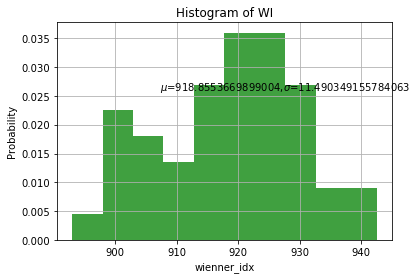

In [110]:
# wienner_idx hist
import networkx as nx
epochsWI_hist_fName = os.path.join(results_dir,
                                 'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_epochs_WI_hist.eps')

wienner_idx = []
for epoch_idx in range(SPMI.shape[0]):
    G = nx.convert_matrix.from_numpy_matrix(SPMI[epoch_idx])  # include the diagonal elements
    wienner_idx.append(nx.algorithms.wiener.wiener_index(G,'weight'))
n, bins, patches = plt.hist(wienner_idx, density=True, facecolor='g', alpha=0.75)
plt.xlabel('wienner_idx')
plt.ylabel('Probability')
plt.title('Histogram of WI')
WI_m = np.mean(wienner_idx)
WI_sigma = np.std(wienner_idx)
plt.text(WI_m-WI_sigma, np.max(n)-.01, r'$\mu$='+str(WI_m)+',$\sigma$='+str(WI_sigma))
plt.grid(True)
plt.savefig(epochsWI_hist_fName)

# Group effect
healthy vs patients
z score (observed mean in the context of bsrg distribution) or cohen'd to characterize effect size - then t test
in a word, one z-network for each subject


# Group effect analysis - pre-TMS vs post-TMS 
## step 1: data loading and SPMI calculation - under construction

In [3]:
########## Import ##############
import os,numpy as np, pandas as pd,mne
################################

########## Customization ##########
embdim = 3
embdelay = 1
###################################

################## Dataset Loading ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subjs2include = ['10']
contraction_type = 'iMC'
session_idx_preTMS = 's01'
session_idx_postTMS = 's02'
# session_idx = 's01'
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                   sep = ',',engine = 'python')

global_results_dir = os.path.join(data_dir,'results')
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)

# Dir in PC
# data_dir = 'E:/important file/Projects/CM-graph/sample_data/'

### pre-TMS data
SPMI_preTMS = None
for subj in subjs2include:
    affected_h = subjInfo[subjInfo['subj_idx']==int(subj)]['affected_h'].values[0]
    epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj,'epochs_hybrid')
    epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj,'epochs_hybrid',
                                      'subj'+subj+'_'+contraction_type+'_'+session_idx_preTMS+'_hybrid_epo.fif')
    epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)
    
    if SPMI_preTMS == None:
        SPMI_preTMS = SPMI_epochs(epochs_hybrid.get_data(),embdim,embdelay)
        for SPMI_idx in range(SPMI_preTMS.shape[0]):
            SPMI_preTMS[SPMI_idx] = chs_remap(SPMI_preTMS[SPMI_idx],epochs_hybrid.info['ch_names'],affected_h)
    else:
        SPMI_preTMS2conctn = SPMI_epochs(epochs_hybrid.get_data(),embdim,embdelay)
        for SPMI_idx in range(SPMI_preTMS2conctn.shape[0]):
            SPMI_preTMS2conctn[SPMI_idx] = chs_remap(SPMI_preTMS2conctn[SPMI_idx],epochs_hybrid.info['ch_names'],affected_h)
        SPMI_preTMS = np.concatenate((SPMI_preTMS,SPMI_preTMS2conctn))

### post-TMS data
SPMI_postTMS = None
for subj in subjs2include:
    affected_h = subjInfo[subjInfo['subj_idx']==int(subj)]['affected_h'].values[0]
    epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj,'epochs_hybrid')
    epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj,'epochs_hybrid',
                                      'subj'+subj+'_'+contraction_type+'_'+session_idx_postTMS+'_hybrid_epo.fif')
    epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)
    
    if SPMI_postTMS == None:
        SPMI_postTMS = SPMI_epochs(epochs_hybrid.get_data(),embdim,embdelay)
        for SPMI_idx in range(SPMI_postTMS.shape[0]):
            SPMI_postTMS[SPMI_idx] = chs_remap(SPMI_postTMS[SPMI_idx],epochs_hybrid.info['ch_names'],affected_h)
    else:
        SPMI_postTMS2conctn = SPMI_epochs(epochs_hybrid.get_data(),embdim,embdelay)
        for SPMI_idx in range(SPMI_postTMS2conctn.shape[0]):
            SPMI_postTMS2conctn[SPMI_idx] = chs_remap(SPMI_postTMS2conctn[SPMI_idx],epochs_hybrid.info['ch_names'],
                                                      affected_h)
        SPMI_postTMS = np.concatenate((SPMI_postTMS,SPMI_postTMS2conctn))        
#####################################################################

Reading D:/Data/MultiEEGEMG_stroke/subj10\epochs_hybrid\subj10_iMC_s01_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading D:/Data/MultiEEGEMG_stroke/subj10\epochs_hybrid\subj10_iMC_s02_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## step 2: PMI calculation

## step 2*: better save the data for later processing

In [4]:
from numpy import savetxt
temp_dir = os.path.join(data_dir,'temp')
pre_SPMI_fName = os.path.join(temp_dir,'pre_SPMI.txt')
post_SPMI_fName = os.path.join(temp_dir,'post_SPMI.txt')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
with open(pre_SPMI_fName, 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(SPMI_preTMS.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in SPMI_preTMS:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.4f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')
with open(post_SPMI_fName, 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(SPMI_postTMS.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in SPMI_postTMS:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.4f') # 4 digits

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')
        

In [90]:
## LOADING script
# Read the array from disk
pre_PMI_fName = os.path.join(temp_dir,'pre_PMI.txt')
post_PMI_fName = os.path.join(temp_dir,'post_PMI.txt')
PMI_preTMS = np.loadtxt(pre_PMI_fName)
PMI_postTMS = np.loadtxt(post_PMI_fName)

n_epochs = PMI_preTMS.shape[0]*PMI_preTMS.shape[1]/40/40
# However, going back to 3D is easy if we know the 
# original shape of the array
PMI_preTMS = PMI_preTMS.reshape((int(n_epochs),40,40))
PMI_postTMS = PMI_postTMS.reshape((int(n_epochs),40,40))

# # Just to check that they're the same...
# assert np.all(n_pre_PMI_data == PMI_preTMS)

## step 3: two-tailed T-test (welch's t test) for the means of two independent samples of scores. Note here we do not assume the variance of two groups are identical.

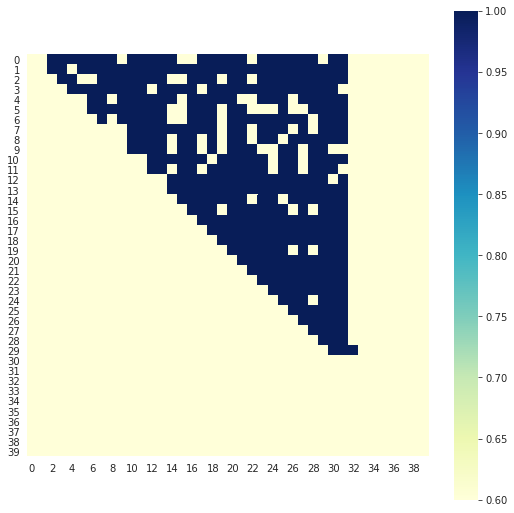

In [12]:
### import ###
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
sig_prePost_m_fName = os.path.join(global_results_dir,'sig_prePost_m.eps')
alpha = 0.005
#############
t_stats = np.zeros((SPMI_preTMS.shape[1],SPMI_preTMS.shape[2]))
p_values = np.zeros((SPMI_preTMS.shape[1],SPMI_preTMS.shape[2]))
diff_cons_mask = np.zeros((SPMI_preTMS.shape[1],SPMI_preTMS.shape[2]))
for ch1_idx in range(SPMI_preTMS.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_preTMS.shape[1]):
        SPMI_preTMS_2chs = SPMI_preTMS[:,ch1_idx,ch2_idx]
        SPMI_postTMS_2chs = SPMI_postTMS[:,ch1_idx,ch2_idx]
        t_stat,p_value = stats.ttest_ind(SPMI_preTMS_2chs,SPMI_postTMS_2chs,equal_var = False)
        t_stats[ch1_idx][ch2_idx] = t_stat
        p_values[ch1_idx][ch2_idx] = p_value
        if p_value<alpha:
            diff_cons_mask[ch1_idx][ch2_idx] = 1
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(diff_cons_mask,vmin =.6, square=True,cmap="YlGnBu")
    figure = ax.get_figure()
    figure.savefig(sig_prePost_m_fName)

## step 4: graph visualization

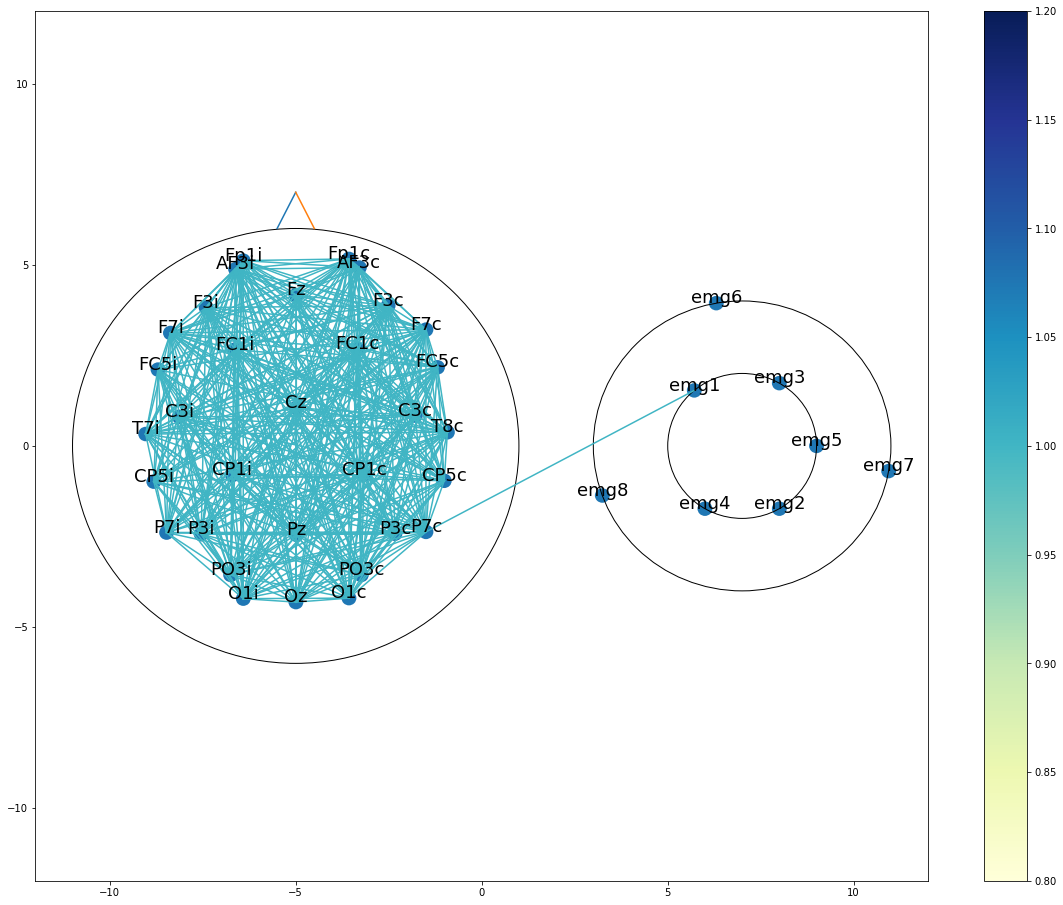

In [24]:
########### customization ###################
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

EMGs=[EMGChannel(2,130,'emg1'),EMGChannel(2,-60,'emg2'),EMGChannel(2, 60,'emg3'),EMGChannel(2,-120,'emg4'),
      EMGChannel(2, 0,'emg5'),EMGChannel(4,100,'emg6'),EMGChannel(4, -10,'emg7'),
      EMGChannel(4,200,'emg8')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_lParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image] 

sig_prePost_g_fName = os.path.join(global_results_dir,'sig_prePost_g.eps')
#########################################

# fig= plt.figure(figsize=(18, 18), facecolor='w', edgecolor='k')
fig,ax = plt.subplots(figsize=(20, 16))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
fig,ax = graph_plot(diff_cons_mask,fig,ax)
# fig.colorbar(ax.images,cax,ax=ax)

plt.xlim([-12,12])
plt.ylim([-12,12])
plt.show()
fig.savefig(sig_prePost_g_fName)


## step 5: box plot visualization - to trace the diff
too many differences, so one boxplot is created for each connection 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-F3i_pre v.s. Fp1i-F3i_post: t-test independent samples with Bonferroni correction, P_val=3.067e-09 stat=6.594e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-F7i_pre v.s. Fp1i-F7i_post: t-test independent samples with Bonferroni correction, P_val=3.909e-15 stat=9.496e+00
Fp1i-FC1i_pre v.s. Fp1i-FC1i_post: t-test independent samples with Bonferroni correction, P_val=4.673e-03 stat=2.903e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-FC5i_pre v.s. Fp1i-FC5i_post: t-test independent samples with Bonferroni correction, P_val=1.728e-07 stat=5.678e+00
Fp1i-C3i_pre v.s. Fp1i-C3i_post: t-test independent samples with Bonferroni correction, P_val=2.664e-03 stat=3.092e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-T7i_pre v.s. Fp1i-T7i_post: t-test independent samples with Bonferroni correction, P_val=7.684e-10 stat=6.899e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-CP1i_pre v.s. Fp1i-CP1i_post: t-test independent samples with Bonferroni correction, P_val=1.004e-04 stat=-4.075e+00
Fp1i-P3i_pre v.s. Fp1i-P3i_post: t-test independent samples with Bonferroni correction, P_val=7.965e-10 stat=-6.891e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-P7i_pre v.s. Fp1i-P7i_post: t-test independent samples with Bonferroni correction, P_val=7.889e-05 stat=-4.142e+00
Fp1i-PO3i_pre v.s. Fp1i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=9.781e-21 stat=-1.226e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-O1i_pre v.s. Fp1i-O1i_post: t-test independent samples with Bonferroni correction, P_val=7.344e-29 stat=-1.661e+01
Fp1i-Fz_pre v.s. Fp1i-Fz_post: t-test independent samples with Bonferroni correction, P_val=2.121e-07 stat=5.630e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-Oz_pre v.s. Fp1i-Oz_post: t-test independent samples with Bonferroni correction, P_val=2.799e-19 stat=-1.153e+01
Fp1i-Fp1c_pre v.s. Fp1i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=3.899e-20 stat=-1.196e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-AF3c_pre v.s. Fp1i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=3.564e-05 stat=4.356e+00
Fp1i-F3c_pre v.s. Fp1i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.128e-04 stat=4.043e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-F7c_pre v.s. Fp1i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.168e-09 stat=-6.807e+00
Fp1i-FC5c_pre v.s. Fp1i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=3.751e-11 stat=-7.553e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-C3c_pre v.s. Fp1i-C3c_post: t-test independent samples with Bonferroni correction, P_val=2.599e-16 stat=-1.007e+01
Fp1i-T8c_pre v.s. Fp1i-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.381e-16 stat=-1.020e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-CP1c_pre v.s. Fp1i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.958e-07 stat=-5.648e+00
Fp1i-CP5c_pre v.s. Fp1i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=3.128e-10 stat=-7.095e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-P3c_pre v.s. Fp1i-P3c_post: t-test independent samples with Bonferroni correction, P_val=2.143e-08 stat=-6.158e+00
Fp1i-PO3c_pre v.s. Fp1i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.827e-16 stat=-1.014e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1i-O1c_pre v.s. Fp1i-O1c_post: t-test independent samples with Bonferroni correction, P_val=1.818e-16 stat=-1.014e+01
AF3i-F3i_pre v.s. AF3i-F3i_post: t-test independent samples with Bonferroni correction, P_val=2.890e-04 stat=-3.776e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-F7i_pre v.s. AF3i-F7i_post: t-test independent samples with Bonferroni correction, P_val=3.660e-11 stat=7.559e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-FC5i_pre v.s. AF3i-FC5i_post: t-test independent samples with Bonferroni correction, P_val=7.161e-07 stat=5.341e+00
AF3i-C3i_pre v.s. AF3i-C3i_post: t-test independent samples with Bonferroni correction, P_val=1.804e-19 stat=-1.162e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-T7i_pre v.s. AF3i-T7i_post: t-test independent samples with Bonferroni correction, P_val=7.230e-10 stat=-6.912e+00
AF3i-CP1i_pre v.s. AF3i-CP1i_post: t-test independent samples with Bonferroni correction, P_val=6.627e-35 stat=-2.027e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-CP5i_pre v.s. AF3i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=4.030e-14 stat=-9.004e+00
AF3i-P3i_pre v.s. AF3i-P3i_post: t-test independent samples with Bonferroni correction, P_val=1.724e-31 stat=-1.815e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-P7i_pre v.s. AF3i-P7i_post: t-test independent samples with Bonferroni correction, P_val=7.649e-33 stat=-1.897e+01
AF3i-PO3i_pre v.s. AF3i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=6.611e-46 stat=-2.825e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-O1i_pre v.s. AF3i-O1i_post: t-test independent samples with Bonferroni correction, P_val=1.064e-49 stat=-3.150e+01
AF3i-Fz_pre v.s. AF3i-Fz_post: t-test independent samples with Bonferroni correction, P_val=4.572e-17 stat=-1.044e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-Cz_pre v.s. AF3i-Cz_post: t-test independent samples with Bonferroni correction, P_val=1.280e-19 stat=-1.170e+01
AF3i-Pz_pre v.s. AF3i-Pz_post: t-test independent samples with Bonferroni correction, P_val=1.902e-22 stat=-1.313e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-Oz_pre v.s. AF3i-Oz_post: t-test independent samples with Bonferroni correction, P_val=6.944e-19 stat=-1.133e+01
AF3i-Fp1c_pre v.s. AF3i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=2.444e-58 stat=-4.012e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-AF3c_pre v.s. AF3i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=2.624e-36 stat=-2.118e+01
AF3i-F3c_pre v.s. AF3i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.841e-04 stat=3.905e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-F7c_pre v.s. AF3i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.315e-35 stat=-2.072e+01
AF3i-FC1c_pre v.s. AF3i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=8.552e-14 stat=-8.845e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-FC5c_pre v.s. AF3i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.365e-27 stat=-1.576e+01
AF3i-C3c_pre v.s. AF3i-C3c_post: t-test independent samples with Bonferroni correction, P_val=1.774e-23 stat=-1.367e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-T8c_pre v.s. AF3i-T8c_post: t-test independent samples with Bonferroni correction, P_val=7.787e-19 stat=-1.131e+01
AF3i-CP1c_pre v.s. AF3i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.680e-26 stat=-1.529e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-CP5c_pre v.s. AF3i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.541e-26 stat=-1.531e+01
AF3i-P3c_pre v.s. AF3i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.114e-11 stat=-7.813e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-P7c_pre v.s. AF3i-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.149e-14 stat=9.268e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3i-PO3c_pre v.s. AF3i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=6.452e-35 stat=-2.027e+01
AF3i-O1c_pre v.s. AF3i-O1c_post: t-test independent samples with Bonferroni correction, P_val=1.256e-24 stat=-1.428e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-F7i_pre v.s. F3i-F7i_post: t-test independent samples with Bonferroni correction, P_val=2.000e-23 stat=1.364e+01
F3i-FC1i_pre v.s. F3i-FC1i_post: t-test independent samples with Bonferroni correction, P_val=3.226e-14 stat=9.051e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-T7i_pre v.s. F3i-T7i_post: t-test independent samples with Bonferroni correction, P_val=1.079e-08 stat=6.313e+00
F3i-CP1i_pre v.s. F3i-CP1i_post: t-test independent samples with Bonferroni correction, P_val=1.340e-06 stat=-5.189e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-CP5i_pre v.s. F3i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=4.778e-03 stat=-2.895e+00
F3i-P3i_pre v.s. F3i-P3i_post: t-test independent samples with Bonferroni correction, P_val=1.689e-24 stat=-1.421e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-P7i_pre v.s. F3i-P7i_post: t-test independent samples with Bonferroni correction, P_val=3.053e-05 stat=-4.398e+00
F3i-PO3i_pre v.s. F3i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=1.798e-28 stat=-1.639e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-O1i_pre v.s. F3i-O1i_post: t-test independent samples with Bonferroni correction, P_val=2.052e-45 stat=-2.785e+01
F3i-Pz_pre v.s. F3i-Pz_post: t-test independent samples with Bonferroni correction, P_val=9.223e-08 stat=5.824e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-Oz_pre v.s. F3i-Oz_post: t-test independent samples with Bonferroni correction, P_val=2.063e-12 stat=-8.172e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-Fp1c_pre v.s. F3i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=1.423e-34 stat=-2.005e+01
F3i-F3c_pre v.s. F3i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.281e-12 stat=8.273e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-F7c_pre v.s. F3i-F7c_post: t-test independent samples with Bonferroni correction, P_val=4.309e-21 stat=-1.244e+01
F3i-FC5c_pre v.s. F3i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=1.867e-15 stat=-9.652e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-C3c_pre v.s. F3i-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.215e-13 stat=-8.566e+00
F3i-T8c_pre v.s. F3i-T8c_post: t-test independent samples with Bonferroni correction, P_val=3.685e-04 stat=-3.705e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-CP1c_pre v.s. F3i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.466e-03 stat=-3.285e+00
F3i-CP5c_pre v.s. F3i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=5.885e-12 stat=-7.949e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-P3c_pre v.s. F3i-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.401e-06 stat=-4.845e+00
F3i-P7c_pre v.s. F3i-P7c_post: t-test independent samples with Bonferroni correction, P_val=5.354e-18 stat=1.089e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3i-PO3c_pre v.s. F3i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=2.535e-22 stat=-1.307e+01
F3i-O1c_pre v.s. F3i-O1c_post: t-test independent samples with Bonferroni correction, P_val=1.711e-17 stat=-1.065e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-FC1i_pre v.s. F7i-FC1i_post: t-test independent samples with Bonferroni correction, P_val=2.745e-35 stat=2.051e+01
F7i-FC5i_pre v.s. F7i-FC5i_post: t-test independent samples with Bonferroni correction, P_val=4.247e-32 stat=1.851e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-C3i_pre v.s. F7i-C3i_post: t-test independent samples with Bonferroni correction, P_val=1.333e-23 stat=1.373e+01
F7i-T7i_pre v.s. F7i-T7i_post: t-test independent samples with Bonferroni correction, P_val=7.945e-48 stat=2.986e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-CP1i_pre v.s. F7i-CP1i_post: t-test independent samples with Bonferroni correction, P_val=2.634e-24 stat=1.410e+01
F7i-CP5i_pre v.s. F7i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=9.597e-31 stat=1.770e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-P3i_pre v.s. F7i-P3i_post: t-test independent samples with Bonferroni correction, P_val=5.590e-26 stat=1.500e+01
F7i-P7i_pre v.s. F7i-P7i_post: t-test independent samples with Bonferroni correction, P_val=1.442e-26 stat=-1.532e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-O1i_pre v.s. F7i-O1i_post: t-test independent samples with Bonferroni correction, P_val=4.694e-22 stat=-1.293e+01
F7i-Fz_pre v.s. F7i-Fz_post: t-test independent samples with Bonferroni correction, P_val=1.866e-31 stat=1.813e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-Cz_pre v.s. F7i-Cz_post: t-test independent samples with Bonferroni correction, P_val=1.692e-40 stat=2.408e+01
F7i-Pz_pre v.s. F7i-Pz_post: t-test independent samples with Bonferroni correction, P_val=2.039e-14 stat=-9.148e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-Fp1c_pre v.s. F7i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=4.277e-31 stat=-1.791e+01
F7i-AF3c_pre v.s. F7i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=1.241e-04 stat=-4.016e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-F3c_pre v.s. F7i-F3c_post: t-test independent samples with Bonferroni correction, P_val=4.469e-57 stat=-3.874e+01
F7i-F7c_pre v.s. F7i-F7c_post: t-test independent samples with Bonferroni correction, P_val=2.940e-10 stat=7.109e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-FC1c_pre v.s. F7i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=4.381e-36 stat=2.103e+01
F7i-FC5c_pre v.s. F7i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=7.863e-25 stat=1.438e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-C3c_pre v.s. F7i-C3c_post: t-test independent samples with Bonferroni correction, P_val=1.091e-17 stat=1.074e+01
F7i-T8c_pre v.s. F7i-T8c_post: t-test independent samples with Bonferroni correction, P_val=4.088e-48 stat=-3.011e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-CP1c_pre v.s. F7i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=7.380e-33 stat=1.898e+01
F7i-CP5c_pre v.s. F7i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=9.353e-29 stat=1.655e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-P3c_pre v.s. F7i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.448e-36 stat=2.135e+01
F7i-P7c_pre v.s. F7i-P7c_post: t-test independent samples with Bonferroni correction, P_val=4.090e-35 stat=2.040e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7i-PO3c_pre v.s. F7i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=3.090e-07 stat=5.541e+00
FC1i-C3i_pre v.s. FC1i-C3i_post: t-test independent samples with Bonferroni correction, P_val=4.229e-19 stat=1.144e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-T7i_pre v.s. FC1i-T7i_post: t-test independent samples with Bonferroni correction, P_val=4.960e-09 stat=6.487e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-CP5i_pre v.s. FC1i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=4.864e-05 stat=4.273e+00
FC1i-P3i_pre v.s. FC1i-P3i_post: t-test independent samples with Bonferroni correction, P_val=8.275e-09 stat=-6.373e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-P7i_pre v.s. FC1i-P7i_post: t-test independent samples with Bonferroni correction, P_val=4.908e-19 stat=1.141e+01
FC1i-PO3i_pre v.s. FC1i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=4.952e-20 stat=-1.190e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-O1i_pre v.s. FC1i-O1i_post: t-test independent samples with Bonferroni correction, P_val=2.136e-37 stat=-2.191e+01
FC1i-Fz_pre v.s. FC1i-Fz_post: t-test independent samples with Bonferroni correction, P_val=4.609e-11 stat=7.509e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-Pz_pre v.s. FC1i-Pz_post: t-test independent samples with Bonferroni correction, P_val=3.284e-42 stat=2.535e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-Oz_pre v.s. FC1i-Oz_post: t-test independent samples with Bonferroni correction, P_val=1.466e-14 stat=-9.217e+00
FC1i-Fp1c_pre v.s. FC1i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=2.237e-26 stat=-1.522e+01

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



FC1i-AF3c_pre v.s. FC1i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=2.556e-11 stat=7.636e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-F3c_pre v.s. FC1i-F3c_post: t-test independent samples with Bonferroni correction, P_val=6.285e-51 stat=3.262e+01
FC1i-FC5c_pre v.s. FC1i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=8.664e-08 stat=-5.838e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-C3c_pre v.s. FC1i-C3c_post: t-test independent samples with Bonferroni correction, P_val=5.047e-05 stat=-4.263e+00
FC1i-T8c_pre v.s. FC1i-T8c_post: t-test independent samples with Bonferroni correction, P_val=4.417e-11 stat=7.518e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-CP5c_pre v.s. FC1i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=2.057e-09 stat=-6.682e+00
FC1i-P3c_pre v.s. FC1i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.820e-11 stat=-7.708e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-P7c_pre v.s. FC1i-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.855e-28 stat=1.627e+01
FC1i-PO3c_pre v.s. FC1i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.312e-20 stat=-1.219e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1i-O1c_pre v.s. FC1i-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.196e-18 stat=-1.109e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-C3i_pre v.s. FC5i-C3i_post: t-test independent samples with Bonferroni correction, P_val=2.356e-19 stat=-1.157e+01
FC5i-T7i_pre v.s. FC5i-T7i_post: t-test independent samples with Bonferroni correction, P_val=9.968e-17 stat=1.027e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-CP1i_pre v.s. FC5i-CP1i_post: t-test independent samples with Bonferroni correction, P_val=2.678e-21 stat=-1.254e+01
FC5i-CP5i_pre v.s. FC5i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=6.643e-07 stat=5.359e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-P3i_pre v.s. FC5i-P3i_post: t-test independent samples with Bonferroni correction, P_val=3.765e-09 stat=6.548e+00
FC5i-P7i_pre v.s. FC5i-P7i_post: t-test independent samples with Bonferroni correction, P_val=1.273e-07 stat=5.749e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-PO3i_pre v.s. FC5i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=3.604e-32 stat=-1.856e+01
FC5i-O1i_pre v.s. FC5i-O1i_post: t-test independent samples with Bonferroni correction, P_val=4.396e-40 stat=-2.378e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-Pz_pre v.s. FC5i-Pz_post: t-test independent samples with Bonferroni correction, P_val=1.596e-23 stat=1.369e+01
FC5i-Oz_pre v.s. FC5i-Oz_post: t-test independent samples with Bonferroni correction, P_val=7.241e-10 stat=-6.912e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-Fp1c_pre v.s. FC5i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=2.220e-04 stat=3.852e+00
FC5i-F3c_pre v.s. FC5i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.447e-35 stat=2.069e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-F7c_pre v.s. FC5i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.239e-09 stat=6.794e+00
FC5i-T8c_pre v.s. FC5i-T8c_post: t-test independent samples with Bonferroni correction, P_val=7.504e-09 stat=6.395e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-P3c_pre v.s. FC5i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.160e-09 stat=6.809e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-P7c_pre v.s. FC5i-P7c_post: t-test independent samples with Bonferroni correction, P_val=6.904e-32 stat=1.839e+01
FC5i-PO3c_pre v.s. FC5i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=5.512e-11 stat=-7.471e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5i-O1c_pre v.s. FC5i-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.536e-13 stat=-8.616e+00
C3i-T7i_pre v.s. C3i-T7i_post: t-test independent samples with Bonferroni correction, P_val=2.449e-11 stat=7.645e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-CP5i_pre v.s. C3i-CP5i_post: t-test independent samples with Bonferroni correction, P_val=2.764e-03 stat=3.080e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-P3i_pre v.s. C3i-P3i_post: t-test independent samples with Bonferroni correction, P_val=1.803e-39 stat=-2.334e+01
C3i-P7i_pre v.s. C3i-P7i_post: t-test independent samples with Bonferroni correction, P_val=7.025e-05 stat=-4.174e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-PO3i_pre v.s. C3i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=2.098e-33 stat=-1.932e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-O1i_pre v.s. C3i-O1i_post: t-test independent samples with Bonferroni correction, P_val=1.988e-40 stat=-2.403e+01
C3i-Pz_pre v.s. C3i-Pz_post: t-test independent samples with Bonferroni correction, P_val=6.224e-11 stat=7.444e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-Oz_pre v.s. C3i-Oz_post: t-test independent samples with Bonferroni correction, P_val=6.028e-05 stat=-4.215e+00
C3i-Fp1c_pre v.s. C3i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=1.624e-45 stat=-2.793e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-F3c_pre v.s. C3i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.921e-03 stat=3.198e+00
C3i-F7c_pre v.s. C3i-F7c_post: t-test independent samples with Bonferroni correction, P_val=6.633e-29 stat=-1.663e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-FC1c_pre v.s. C3i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=8.727e-04 stat=3.447e+00
C3i-FC5c_pre v.s. C3i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=4.804e-13 stat=-8.481e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-C3c_pre v.s. C3i-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.163e-06 stat=-4.978e+00
C3i-T8c_pre v.s. C3i-T8c_post: t-test independent samples with Bonferroni correction, P_val=3.352e-07 stat=-5.522e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-CP1c_pre v.s. C3i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.687e-03 stat=3.240e+00
C3i-CP5c_pre v.s. C3i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.371e-04 stat=-3.989e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-P7c_pre v.s. C3i-P7c_post: t-test independent samples with Bonferroni correction, P_val=6.122e-27 stat=1.553e+01
C3i-PO3c_pre v.s. C3i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.249e-14 stat=-9.251e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3i-O1c_pre v.s. C3i-O1c_post: t-test independent samples with Bonferroni correction, P_val=4.097e-04 stat=-3.674e+00
T7i-P3i_pre v.s. T7i-P3i_post: t-test independent samples with Bonferroni correction, P_val=9.358e-05 stat=-4.095e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-P7i_pre v.s. T7i-P7i_post: t-test independent samples with Bonferroni correction, P_val=1.291e-20 stat=1.220e+01
T7i-PO3i_pre v.s. T7i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=1.840e-20 stat=-1.212e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-O1i_pre v.s. T7i-O1i_post: t-test independent samples with Bonferroni correction, P_val=6.166e-28 stat=-1.608e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-Fz_pre v.s. T7i-Fz_post: t-test independent samples with Bonferroni correction, P_val=3.097e-03 stat=3.042e+00
T7i-Cz_pre v.s. T7i-Cz_post: t-test independent samples with Bonferroni correction, P_val=2.314e-03 stat=3.138e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-Pz_pre v.s. T7i-Pz_post: t-test independent samples with Bonferroni correction, P_val=2.353e-26 stat=1.521e+01
T7i-Oz_pre v.s. T7i-Oz_post: t-test independent samples with Bonferroni correction, P_val=2.582e-05 stat=-4.442e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-Fp1c_pre v.s. T7i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=3.662e-21 stat=-1.248e+01
T7i-F3c_pre v.s. T7i-F3c_post: t-test independent samples with Bonferroni correction, P_val=2.515e-41 stat=2.469e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-F7c_pre v.s. T7i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.985e-07 stat=-5.645e+00
T7i-FC5c_pre v.s. T7i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.046e-06 stat=-5.086e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-C3c_pre v.s. T7i-C3c_post: t-test independent samples with Bonferroni correction, P_val=9.798e-04 stat=-3.411e+00
T7i-T8c_pre v.s. T7i-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.944e-03 stat=3.059e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-CP5c_pre v.s. T7i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=6.124e-04 stat=-3.554e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-P7c_pre v.s. T7i-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.447e-35 stat=2.069e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T7i-PO3c_pre v.s. T7i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=8.598e-12 stat=-7.868e+00
T7i-O1c_pre v.s. T7i-O1c_post: t-test independent samples with Bonferroni correction, P_val=6.383e-08 stat=-5.909e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-P3i_pre v.s. CP1i-P3i_post: t-test independent samples with Bonferroni correction, P_val=9.519e-50 stat=-3.154e+01
CP1i-P7i_pre v.s. CP1i-P7i_post: t-test independent samples with Bonferroni correction, P_val=1.501e-03 stat=-3.277e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-PO3i_pre v.s. CP1i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=4.966e-31 stat=-1.787e+01
CP1i-O1i_pre v.s. CP1i-O1i_post: t-test independent samples with Bonferroni correction, P_val=1.003e-37 stat=-2.213e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-Cz_pre v.s. CP1i-Cz_post: t-test independent samples with Bonferroni correction, P_val=7.654e-04 stat=-3.487e+00
CP1i-Pz_pre v.s. CP1i-Pz_post: t-test independent samples with Bonferroni correction, P_val=2.190e-40 stat=2.400e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-Fp1c_pre v.s. CP1i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=4.373e-41 stat=-2.451e+01
CP1i-F3c_pre v.s. CP1i-F3c_post: t-test independent samples with Bonferroni correction, P_val=9.395e-11 stat=7.356e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-F7c_pre v.s. CP1i-F7c_post: t-test independent samples with Bonferroni correction, P_val=7.948e-35 stat=-2.022e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-FC5c_pre v.s. CP1i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=3.509e-31 stat=-1.796e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-C3c_pre v.s. CP1i-C3c_post: t-test independent samples with Bonferroni correction, P_val=4.045e-19 stat=-1.145e+01
CP1i-CP1c_pre v.s. CP1i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=3.553e-05 stat=4.357e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-CP5c_pre v.s. CP1i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.278e-20 stat=-1.220e+01
CP1i-P3c_pre v.s. CP1i-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.393e-05 stat=-4.245e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-P7c_pre v.s. CP1i-P7c_post: t-test independent samples with Bonferroni correction, P_val=6.563e-25 stat=1.443e+01
CP1i-PO3c_pre v.s. CP1i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=2.042e-25 stat=-1.470e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1i-O1c_pre v.s. CP1i-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.194e-03 stat=-3.155e+00
CP5i-P3i_pre v.s. CP5i-P3i_post: t-test independent samples with Bonferroni correction, P_val=3.581e-06 stat=-4.947e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-P7i_pre v.s. CP5i-P7i_post: t-test independent samples with Bonferroni correction, P_val=5.706e-35 stat=2.031e+01
CP5i-PO3i_pre v.s. CP5i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=1.152e-14 stat=-9.268e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-O1i_pre v.s. CP5i-O1i_post: t-test independent samples with Bonferroni correction, P_val=7.999e-26 stat=-1.492e+01
CP5i-Cz_pre v.s. CP5i-Cz_post: t-test independent samples with Bonferroni correction, P_val=9.468e-13 stat=8.337e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-Pz_pre v.s. CP5i-Pz_post: t-test independent samples with Bonferroni correction, P_val=3.068e-41 stat=2.462e+01
CP5i-Fp1c_pre v.s. CP5i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=6.299e-26 stat=-1.497e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-F3c_pre v.s. CP5i-F3c_post: t-test independent samples with Bonferroni correction, P_val=2.028e-41 stat=2.476e+01
CP5i-F7c_pre v.s. CP5i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.640e-04 stat=3.938e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-FC1c_pre v.s. CP5i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=3.409e-03 stat=3.010e+00
CP5i-T8c_pre v.s. CP5i-T8c_post: t-test independent samples with Bonferroni correction, P_val=3.560e-10 stat=7.067e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-CP1c_pre v.s. CP5i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.120e-10 stat=7.318e+00
CP5i-P3c_pre v.s. CP5i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.125e-14 stat=9.273e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5i-P7c_pre v.s. CP5i-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.623e-38 stat=2.268e+01
P3i-PO3i_pre v.s. P3i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=4.542e-53 stat=-3.465e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-O1i_pre v.s. P3i-O1i_post: t-test independent samples with Bonferroni correction, P_val=5.555e-43 stat=-2.593e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-Fz_pre v.s. P3i-Fz_post: t-test independent samples with Bonferroni correction, P_val=2.901e-29 stat=-1.684e+01
P3i-Cz_pre v.s. P3i-Cz_post: t-test independent samples with Bonferroni correction, P_val=1.110e-03 stat=-3.372e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-Pz_pre v.s. P3i-Pz_post: t-test independent samples with Bonferroni correction, P_val=4.615e-36 stat=2.102e+01
P3i-Oz_pre v.s. P3i-Oz_post: t-test independent samples with Bonferroni correction, P_val=2.725e-04 stat=-3.793e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-AF3c_pre v.s. P3i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=3.686e-32 stat=-1.855e+01
P3i-F3c_pre v.s. P3i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.501e-46 stat=2.878e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-F7c_pre v.s. P3i-F7c_post: t-test independent samples with Bonferroni correction, P_val=3.402e-03 stat=3.011e+00
P3i-FC1c_pre v.s. P3i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=4.808e-10 stat=-7.001e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-FC5c_pre v.s. P3i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=5.906e-04 stat=-3.565e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-T8c_pre v.s. P3i-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.687e-08 stat=6.212e+00
P3i-CP1c_pre v.s. P3i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=4.795e-05 stat=-4.277e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-P3c_pre v.s. P3i-P3c_post: t-test independent samples with Bonferroni correction, P_val=2.880e-18 stat=1.103e+01
P3i-P7c_pre v.s. P3i-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.742e-48 stat=3.026e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3i-PO3c_pre v.s. P3i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.907e-15 stat=-9.647e+00
P3i-O1c_pre v.s. P3i-O1c_post: t-test independent samples with Bonferroni correction, P_val=4.470e-12 stat=-8.008e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-PO3i_pre v.s. P7i-PO3i_post: t-test independent samples with Bonferroni correction, P_val=4.883e-15 stat=-9.449e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-O1i_pre v.s. P7i-O1i_post: t-test independent samples with Bonferroni correction, P_val=8.043e-37 stat=-2.152e+01
P7i-Cz_pre v.s. P7i-Cz_post: t-test independent samples with Bonferroni correction, P_val=1.872e-09 stat=6.703e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-Pz_pre v.s. P7i-Pz_post: t-test independent samples with Bonferroni correction, P_val=3.188e-50 stat=-3.197e+01
P7i-Fp1c_pre v.s. P7i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=1.165e-38 stat=-2.278e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-AF3c_pre v.s. P7i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=5.864e-51 stat=-3.265e+01
P7i-F3c_pre v.s. P7i-F3c_post: t-test independent samples with Bonferroni correction, P_val=2.487e-45 stat=-2.778e+01

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



P7i-F7c_pre v.s. P7i-F7c_post: t-test independent samples with Bonferroni correction, P_val=5.390e-36 stat=-2.097e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-FC1c_pre v.s. P7i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.861e-05 stat=4.528e+00
P7i-FC5c_pre v.s. P7i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=4.025e-13 stat=-8.518e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-T8c_pre v.s. P7i-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.218e-48 stat=-3.034e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-CP1c_pre v.s. P7i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=6.660e-04 stat=3.529e+00
P7i-P3c_pre v.s. P7i-P3c_post: t-test independent samples with Bonferroni correction, P_val=2.612e-18 stat=1.105e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-P7c_pre v.s. P7i-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.455e-32 stat=1.880e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7i-PO3c_pre v.s. P7i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=8.342e-11 stat=-7.381e+00
PO3i-Fz_pre v.s. PO3i-Fz_post: t-test independent samples with Bonferroni correction, P_val=2.124e-27 stat=-1.578e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-Cz_pre v.s. PO3i-Cz_post: t-test independent samples with Bonferroni correction, P_val=1.313e-26 stat=-1.535e+01
PO3i-Pz_pre v.s. PO3i-Pz_post: t-test independent samples with Bonferroni correction, P_val=1.450e-34 stat=2.005e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-Oz_pre v.s. PO3i-Oz_post: t-test independent samples with Bonferroni correction, P_val=5.500e-36 stat=2.097e+01
PO3i-Fp1c_pre v.s. PO3i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=8.469e-47 stat=-2.899e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-AF3c_pre v.s. PO3i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=4.446e-36 stat=-2.103e+01
PO3i-F3c_pre v.s. PO3i-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.895e-04 stat=-3.897e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-F7c_pre v.s. PO3i-F7c_post: t-test independent samples with Bonferroni correction, P_val=1.300e-43 stat=-2.642e+01
PO3i-FC1c_pre v.s. PO3i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.374e-26 stat=-1.534e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-FC5c_pre v.s. PO3i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=5.513e-42 stat=-2.518e+01
PO3i-C3c_pre v.s. PO3i-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.312e-33 stat=-1.919e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-T8c_pre v.s. PO3i-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.968e-06 stat=-4.994e+00
PO3i-CP1c_pre v.s. PO3i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=3.319e-13 stat=-8.559e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-CP5c_pre v.s. PO3i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=7.976e-30 stat=-1.716e+01
PO3i-P3c_pre v.s. PO3i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.757e-06 stat=-5.123e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


PO3i-P7c_pre v.s. PO3i-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.938e-28 stat=1.627e+01
PO3i-O1c_pre v.s. PO3i-O1c_post: t-test independent samples with Bonferroni correction, P_val=5.483e-25 stat=1.447e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-Fz_pre v.s. O1i-Fz_post: t-test independent samples with Bonferroni correction, P_val=2.443e-41 stat=-2.470e+01
O1i-Cz_pre v.s. O1i-Cz_post: t-test independent samples with Bonferroni correction, P_val=3.175e-39 stat=-2.317e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-Pz_pre v.s. O1i-Pz_post: t-test independent samples with Bonferroni correction, P_val=2.077e-03 stat=3.173e+00
O1i-Oz_pre v.s. O1i-Oz_post: t-test independent samples with Bonferroni correction, P_val=1.009e-14 stat=-9.296e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-Fp1c_pre v.s. O1i-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=3.169e-49 stat=-3.108e+01
O1i-AF3c_pre v.s. O1i-AF3c_post: t-test independent samples with Bonferroni correction, P_val=6.079e-49 stat=-3.083e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-F3c_pre v.s. O1i-F3c_post: t-test independent samples with Bonferroni correction, P_val=4.333e-22 stat=-1.295e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-F7c_pre v.s. O1i-F7c_post: t-test independent samples with Bonferroni correction, P_val=5.751e-41 stat=-2.442e+01
O1i-FC1c_pre v.s. O1i-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.161e-39 stat=-2.348e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-FC5c_pre v.s. O1i-FC5c_post: t-test independent samples with Bonferroni correction, P_val=8.259e-44 stat=-2.657e+01
O1i-C3c_pre v.s. O1i-C3c_post: t-test independent samples with Bonferroni correction, P_val=5.260e-49 stat=-3.088e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-T8c_pre v.s. O1i-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.143e-16 stat=-1.024e+01
O1i-CP1c_pre v.s. O1i-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.157e-41 stat=-2.494e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-CP5c_pre v.s. O1i-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.190e-50 stat=-3.236e+01
O1i-P3c_pre v.s. O1i-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.143e-48 stat=-3.059e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-P7c_pre v.s. O1i-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.970e-39 stat=-2.319e+01
O1i-PO3c_pre v.s. O1i-PO3c_post: t-test independent samples with Bonferroni correction, P_val=4.271e-40 stat=-2.379e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


O1i-O1c_pre v.s. O1i-O1c_post: t-test independent samples with Bonferroni correction, P_val=3.185e-26 stat=-1.514e+01
Fz-Cz_pre v.s. Fz-Cz_post: t-test independent samples with Bonferroni correction, P_val=4.305e-07 stat=-5.463e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-Pz_pre v.s. Fz-Pz_post: t-test independent samples with Bonferroni correction, P_val=5.958e-25 stat=1.445e+01
Fz-Oz_pre v.s. Fz-Oz_post: t-test independent samples with Bonferroni correction, P_val=1.179e-13 stat=-8.777e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-Fp1c_pre v.s. Fz-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=1.252e-41 stat=-2.491e+01
Fz-AF3c_pre v.s. Fz-AF3c_post: t-test independent samples with Bonferroni correction, P_val=6.186e-04 stat=3.551e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-F3c_pre v.s. Fz-F3c_post: t-test independent samples with Bonferroni correction, P_val=3.268e-27 stat=1.568e+01
Fz-F7c_pre v.s. Fz-F7c_post: t-test independent samples with Bonferroni correction, P_val=6.267e-31 stat=-1.781e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-FC5c_pre v.s. Fz-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.112e-17 stat=-1.060e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-C3c_pre v.s. Fz-C3c_post: t-test independent samples with Bonferroni correction, P_val=1.463e-11 stat=-7.755e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-CP1c_pre v.s. Fz-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.512e-05 stat=-4.582e+00
Fz-CP5c_pre v.s. Fz-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.892e-13 stat=-8.678e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-P3c_pre v.s. Fz-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.800e-07 stat=-5.391e+00
Fz-P7c_pre v.s. Fz-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.126e-25 stat=1.484e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fz-PO3c_pre v.s. Fz-PO3c_post: t-test independent samples with Bonferroni correction, P_val=4.260e-22 stat=-1.295e+01
Fz-O1c_pre v.s. Fz-O1c_post: t-test independent samples with Bonferroni correction, P_val=5.389e-20 stat=-1.189e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-Pz_pre v.s. Cz-Pz_post: t-test independent samples with Bonferroni correction, P_val=3.092e-52 stat=3.385e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-Oz_pre v.s. Cz-Oz_post: t-test independent samples with Bonferroni correction, P_val=1.168e-13 stat=-8.779e+00
Cz-Fp1c_pre v.s. Cz-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=1.031e-21 stat=-1.276e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-F3c_pre v.s. Cz-F3c_post: t-test independent samples with Bonferroni correction, P_val=4.635e-45 stat=2.756e+01
Cz-F7c_pre v.s. Cz-F7c_post: t-test independent samples with Bonferroni correction, P_val=3.499e-05 stat=-4.361e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-FC1c_pre v.s. Cz-FC1c_post: t-test independent samples with Bonferroni correction, P_val=2.077e-03 stat=-3.173e+00
Cz-FC5c_pre v.s. Cz-FC5c_post: t-test independent samples with Bonferroni correction, P_val=7.120e-16 stat=-9.855e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-C3c_pre v.s. Cz-C3c_post: t-test independent samples with Bonferroni correction, P_val=1.029e-06 stat=-5.253e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-T8c_pre v.s. Cz-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.801e-08 stat=6.097e+00
Cz-CP5c_pre v.s. Cz-CP5c_post: t-test independent samples with Bonferroni correction, P_val=6.133e-12 stat=-7.940e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-P7c_pre v.s. Cz-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.187e-34 stat=1.993e+01
Cz-PO3c_pre v.s. Cz-PO3c_post: t-test independent samples with Bonferroni correction, P_val=5.886e-20 stat=-1.187e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cz-O1c_pre v.s. Cz-O1c_post: t-test independent samples with Bonferroni correction, P_val=6.556e-20 stat=-1.184e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-Oz_pre v.s. Pz-Oz_post: t-test independent samples with Bonferroni correction, P_val=4.789e-43 stat=2.598e+01
Pz-Fp1c_pre v.s. Pz-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=3.512e-30 stat=-1.737e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-AF3c_pre v.s. Pz-AF3c_post: t-test independent samples with Bonferroni correction, P_val=2.711e-17 stat=-1.055e+01
Pz-F3c_pre v.s. Pz-F3c_post: t-test independent samples with Bonferroni correction, P_val=7.356e-28 stat=-1.604e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-F7c_pre v.s. Pz-F7c_post: t-test independent samples with Bonferroni correction, P_val=7.583e-06 stat=-4.759e+00
Pz-FC1c_pre v.s. Pz-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.524e-42 stat=2.560e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-FC5c_pre v.s. Pz-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.214e-08 stat=6.151e+00
Pz-C3c_pre v.s. Pz-C3c_post: t-test independent samples with Bonferroni correction, P_val=2.794e-21 stat=1.254e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-T8c_pre v.s. Pz-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.114e-34 stat=-2.012e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-CP1c_pre v.s. Pz-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.439e-57 stat=3.927e+01
Pz-CP5c_pre v.s. Pz-CP5c_post: t-test independent samples with Bonferroni correction, P_val=2.536e-33 stat=1.927e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-P3c_pre v.s. Pz-P3c_post: t-test independent samples with Bonferroni correction, P_val=6.503e-63 stat=4.548e+01
Pz-P7c_pre v.s. Pz-P7c_post: t-test independent samples with Bonferroni correction, P_val=6.720e-55 stat=3.647e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pz-PO3c_pre v.s. Pz-PO3c_post: t-test independent samples with Bonferroni correction, P_val=2.538e-47 stat=2.943e+01
Pz-O1c_pre v.s. Pz-O1c_post: t-test independent samples with Bonferroni correction, P_val=6.662e-36 stat=2.091e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-Fp1c_pre v.s. Oz-Fp1c_post: t-test independent samples with Bonferroni correction, P_val=8.596e-16 stat=-9.816e+00
Oz-AF3c_pre v.s. Oz-AF3c_post: t-test independent samples with Bonferroni correction, P_val=9.137e-16 stat=-9.803e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-F3c_pre v.s. Oz-F3c_post: t-test independent samples with Bonferroni correction, P_val=2.434e-12 stat=8.137e+00
Oz-F7c_pre v.s. Oz-F7c_post: t-test independent samples with Bonferroni correction, P_val=4.005e-16 stat=-9.977e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-FC1c_pre v.s. Oz-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.727e-21 stat=-1.264e+01
Oz-FC5c_pre v.s. Oz-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.758e-30 stat=-1.743e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-C3c_pre v.s. Oz-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.493e-25 stat=-1.457e+01
Oz-T8c_pre v.s. Oz-T8c_post: t-test independent samples with Bonferroni correction, P_val=8.560e-09 stat=6.365e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-CP1c_pre v.s. Oz-CP1c_post: t-test independent samples with Bonferroni correction, P_val=8.079e-16 stat=-9.829e+00
Oz-CP5c_pre v.s. Oz-CP5c_post: t-test independent samples with Bonferroni correction, P_val=3.069e-24 stat=-1.407e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-P3c_pre v.s. Oz-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.264e-32 stat=-1.883e+01
Oz-P7c_pre v.s. Oz-P7c_post: t-test independent samples with Bonferroni correction, P_val=5.301e-47 stat=-2.916e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oz-PO3c_pre v.s. Oz-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.533e-11 stat=7.745e+00
Oz-O1c_pre v.s. Oz-O1c_post: t-test independent samples with Bonferroni correction, P_val=6.879e-10 stat=6.923e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-AF3c_pre v.s. Fp1c-AF3c_post: t-test independent samples with Bonferroni correction, P_val=3.884e-44 stat=-2.683e+01
Fp1c-F3c_pre v.s. Fp1c-F3c_post: t-test independent samples with Bonferroni correction, P_val=3.202e-24 stat=1.406e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-F7c_pre v.s. Fp1c-F7c_post: t-test independent samples with Bonferroni correction, P_val=2.464e-15 stat=-9.593e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-FC1c_pre v.s. Fp1c-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.850e-23 stat=-1.366e+01
Fp1c-FC5c_pre v.s. Fp1c-FC5c_post: t-test independent samples with Bonferroni correction, P_val=8.096e-16 stat=-9.828e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-C3c_pre v.s. Fp1c-C3c_post: t-test independent samples with Bonferroni correction, P_val=2.871e-15 stat=-9.561e+00
Fp1c-T8c_pre v.s. Fp1c-T8c_post: t-test independent samples with Bonferroni correction, P_val=3.438e-07 stat=-5.516e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-CP1c_pre v.s. Fp1c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=5.415e-24 stat=-1.394e+01
Fp1c-CP5c_pre v.s. Fp1c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.793e-09 stat=-6.713e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-P3c_pre v.s. Fp1c-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.275e-04 stat=3.599e+00
Fp1c-P7c_pre v.s. Fp1c-P7c_post: t-test independent samples with Bonferroni correction, P_val=3.606e-29 stat=1.678e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-PO3c_pre v.s. Fp1c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=8.156e-25 stat=-1.438e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fp1c-O1c_pre v.s. Fp1c-O1c_post: t-test independent samples with Bonferroni correction, P_val=3.367e-20 stat=-1.199e+01
AF3c-F3c_pre v.s. AF3c-F3c_post: t-test independent samples with Bonferroni correction, P_val=1.722e-23 stat=-1.368e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3c-F7c_pre v.s. AF3c-F7c_post: t-test independent samples with Bonferroni correction, P_val=2.798e-43 stat=-2.616e+01
AF3c-FC1c_pre v.s. AF3c-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.712e-04 stat=3.926e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3c-FC5c_pre v.s. AF3c-FC5c_post: t-test independent samples with Bonferroni correction, P_val=1.158e-13 stat=-8.781e+00
AF3c-C3c_pre v.s. AF3c-C3c_post: t-test independent samples with Bonferroni correction, P_val=6.022e-08 stat=-5.922e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3c-T8c_pre v.s. AF3c-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.135e-29 stat=-1.707e+01
AF3c-CP5c_pre v.s. AF3c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.099e-09 stat=-6.820e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3c-P7c_pre v.s. AF3c-P7c_post: t-test independent samples with Bonferroni correction, P_val=6.750e-19 stat=1.134e+01
AF3c-PO3c_pre v.s. AF3c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=8.947e-26 stat=-1.489e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AF3c-O1c_pre v.s. AF3c-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.397e-17 stat=-1.057e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-F7c_pre v.s. F3c-F7c_post: t-test independent samples with Bonferroni correction, P_val=5.370e-20 stat=1.189e+01
F3c-FC1c_pre v.s. F3c-FC1c_post: t-test independent samples with Bonferroni correction, P_val=2.734e-39 stat=2.322e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-FC5c_pre v.s. F3c-FC5c_post: t-test independent samples with Bonferroni correction, P_val=2.358e-25 stat=1.466e+01
F3c-C3c_pre v.s. F3c-C3c_post: t-test independent samples with Bonferroni correction, P_val=2.012e-25 stat=1.470e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-T8c_pre v.s. F3c-T8c_post: t-test independent samples with Bonferroni correction, P_val=8.471e-39 stat=-2.287e+01
F3c-CP1c_pre v.s. F3c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.345e-34 stat=2.007e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-CP5c_pre v.s. F3c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=5.622e-27 stat=1.555e+01
F3c-P3c_pre v.s. F3c-P3c_post: t-test independent samples with Bonferroni correction, P_val=2.705e-47 stat=2.941e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-P7c_pre v.s. F3c-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.665e-48 stat=3.027e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F3c-PO3c_pre v.s. F3c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=3.045e-26 stat=1.515e+01
F3c-O1c_pre v.s. F3c-O1c_post: t-test independent samples with Bonferroni correction, P_val=1.312e-08 stat=6.269e+00
F7c-FC1c_pre v.s. F7c-FC1c_post: t-test independent samples with Bonferroni correction, P_val=1.586e-06 stat=-5.148e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7c-FC5c_pre v.s. F7c-FC5c_post: t-test independent samples with Bonferroni correction, P_val=1.714e-06 stat=-5.129e+00
F7c-C3c_pre v.s. F7c-C3c_post: t-test independent samples with Bonferroni correction, P_val=1.585e-04 stat=-3.948e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7c-T8c_pre v.s. F7c-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.170e-04 stat=3.859e+00
F7c-CP1c_pre v.s. F7c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=1.199e-13 stat=-8.774e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7c-CP5c_pre v.s. F7c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.695e-04 stat=-3.929e+00
F7c-P3c_pre v.s. F7c-P3c_post: t-test independent samples with Bonferroni correction, P_val=9.937e-05 stat=4.078e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7c-P7c_pre v.s. F7c-P7c_post: t-test independent samples with Bonferroni correction, P_val=5.797e-26 stat=1.499e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


F7c-PO3c_pre v.s. F7c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.821e-23 stat=-1.366e+01
F7c-O1c_pre v.s. F7c-O1c_post: t-test independent samples with Bonferroni correction, P_val=3.505e-26 stat=-1.511e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1c-FC5c_pre v.s. FC1c-FC5c_post: t-test independent samples with Bonferroni correction, P_val=3.272e-11 stat=-7.583e+00
FC1c-C3c_pre v.s. FC1c-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.710e-08 stat=-6.033e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1c-T8c_pre v.s. FC1c-T8c_post: t-test independent samples with Bonferroni correction, P_val=1.280e-08 stat=6.275e+00
FC1c-CP1c_pre v.s. FC1c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=3.375e-04 stat=-3.731e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1c-CP5c_pre v.s. FC1c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=1.522e-09 stat=-6.749e+00
FC1c-P3c_pre v.s. FC1c-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.118e-09 stat=-6.480e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1c-P7c_pre v.s. FC1c-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.628e-24 stat=1.422e+01
FC1c-PO3c_pre v.s. FC1c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=9.417e-28 stat=-1.598e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC1c-O1c_pre v.s. FC1c-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.361e-23 stat=-1.360e+01
FC5c-C3c_pre v.s. FC5c-C3c_post: t-test independent samples with Bonferroni correction, P_val=3.100e-14 stat=-9.059e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5c-T8c_pre v.s. FC5c-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.047e-09 stat=6.684e+00
FC5c-CP1c_pre v.s. FC5c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=5.176e-26 stat=-1.502e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5c-CP5c_pre v.s. FC5c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=2.438e-10 stat=-7.149e+00
FC5c-P3c_pre v.s. FC5c-P3c_post: t-test independent samples with Bonferroni correction, P_val=1.272e-04 stat=-4.009e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5c-P7c_pre v.s. FC5c-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.380e-12 stat=8.142e+00
FC5c-PO3c_pre v.s. FC5c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.998e-32 stat=-1.871e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FC5c-O1c_pre v.s. FC5c-O1c_post: t-test independent samples with Bonferroni correction, P_val=4.949e-35 stat=-2.035e+01
C3c-T8c_pre v.s. C3c-T8c_post: t-test independent samples with Bonferroni correction, P_val=2.261e-09 stat=6.662e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3c-CP1c_pre v.s. C3c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=2.057e-13 stat=-8.660e+00
C3c-CP5c_pre v.s. C3c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=2.201e-08 stat=-6.152e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3c-P7c_pre v.s. C3c-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.295e-13 stat=8.758e+00
C3c-PO3c_pre v.s. C3c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=9.131e-28 stat=-1.599e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


C3c-O1c_pre v.s. C3c-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.027e-31 stat=-1.810e+01
T8c-CP1c_pre v.s. T8c-CP1c_post: t-test independent samples with Bonferroni correction, P_val=4.198e-07 stat=5.469e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T8c-CP5c_pre v.s. T8c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=3.511e-12 stat=8.059e+00
T8c-P3c_pre v.s. T8c-P3c_post: t-test independent samples with Bonferroni correction, P_val=2.652e-14 stat=9.092e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T8c-P7c_pre v.s. T8c-P7c_post: t-test independent samples with Bonferroni correction, P_val=4.501e-19 stat=1.143e+01
T8c-PO3c_pre v.s. T8c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=4.080e-04 stat=3.675e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


T8c-O1c_pre v.s. T8c-O1c_post: t-test independent samples with Bonferroni correction, P_val=2.103e-05 stat=4.496e+00
CP1c-CP5c_pre v.s. CP1c-CP5c_post: t-test independent samples with Bonferroni correction, P_val=3.820e-28 stat=-1.620e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1c-P3c_pre v.s. CP1c-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.937e-07 stat=-5.386e+00
CP1c-P7c_pre v.s. CP1c-P7c_post: t-test independent samples with Bonferroni correction, P_val=1.290e-18 stat=1.120e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP1c-PO3c_pre v.s. CP1c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=2.491e-28 stat=-1.631e+01
CP1c-O1c_pre v.s. CP1c-O1c_post: t-test independent samples with Bonferroni correction, P_val=8.104e-24 stat=-1.385e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5c-P3c_pre v.s. CP5c-P3c_post: t-test independent samples with Bonferroni correction, P_val=5.528e-05 stat=-4.239e+00
CP5c-P7c_pre v.s. CP5c-P7c_post: t-test independent samples with Bonferroni correction, P_val=2.186e-13 stat=8.647e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CP5c-PO3c_pre v.s. CP5c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=4.015e-31 stat=-1.793e+01
CP5c-O1c_pre v.s. CP5c-O1c_post: t-test independent samples with Bonferroni correction, P_val=9.288e-36 stat=-2.082e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3c-P7c_pre v.s. P3c-P7c_post: t-test independent samples with Bonferroni correction, P_val=8.962e-22 stat=1.279e+01
P3c-PO3c_pre v.s. P3c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=1.418e-22 stat=-1.320e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P3c-O1c_pre v.s. P3c-O1c_post: t-test independent samples with Bonferroni correction, P_val=3.931e-46 stat=-2.843e+01
P7c-PO3c_pre v.s. P7c-PO3c_post: t-test independent samples with Bonferroni correction, P_val=6.081e-17 stat=1.038e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


P7c-O1c_pre v.s. P7c-O1c_post: t-test independent samples with Bonferroni correction, P_val=8.483e-67 stat=-5.054e+01
P7c-emg1_pre v.s. P7c-emg1_post: t-test independent samples with Bonferroni correction, P_val=4.240e-03 stat=-2.936e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


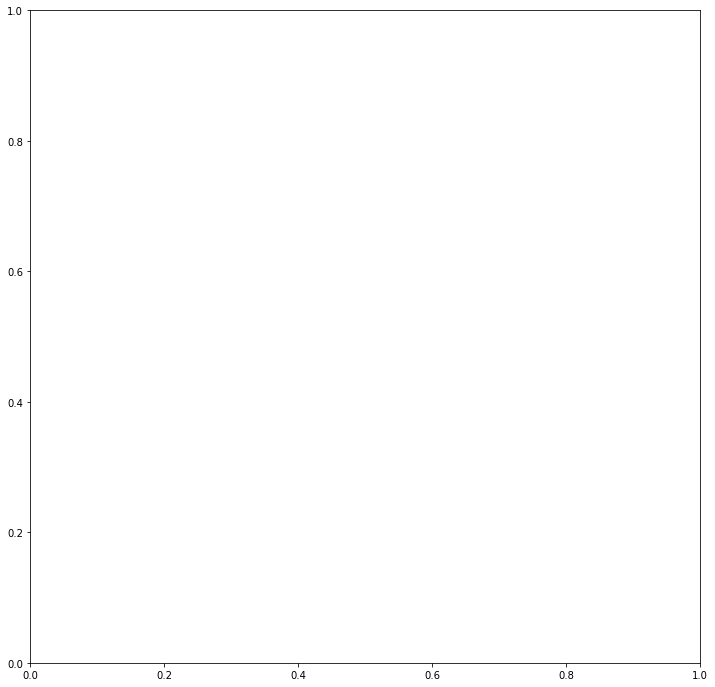

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
diff_prePost_bp_fName = os.path.join(global_results_dir,'diff_prePost_bp.eps')
# df = None
chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T8c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

fig,ax = plt.subplots(figsize=(12, 12))
for ch1_idx in range(SPMI_preTMS.shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,SPMI_preTMS.shape[1]):
        if diff_cons_mask[ch1_idx][ch2_idx] != 0: # significant diff
            ch1_name = chs_list_image[ch1_idx]
            ch2_name = chs_list_image[ch2_idx]
            con_name = [ch1_name +'-'+ ch2_name]*(SPMI_preTMS.shape[0]+SPMI_postTMS.shape[0])
            SPMI = np.concatenate((SPMI_preTMS[:,ch1_idx,ch2_idx],SPMI_postTMS[:,ch1_idx,ch2_idx]))
            order = np.concatenate((np.array(['pre']*SPMI_preTMS.shape[0]),np.array(['post']*SPMI_postTMS.shape[0])))
            data = {'con_name':con_name,'SPMI':SPMI,'order':order}
            df = pd.DataFrame(data, columns = ['con_name','SPMI','order'])
            x = 'con_name'
            y = 'SPMI'
            hue = 'order'
            ax = sns.boxplot(data=df, x=x, y=y, hue=hue,ax=ax)
            add_stat_annotation(ax,data=df, x=x, y=y, 
                        box_pairs=[((con_name[0],"pre"),(con_name[0],"post"))],
                        hue=hue,test='t-test_ind',text_format='full',fontsize=18,verbose=1)
            plt.legend(loc='upper left', bbox_to_anchor = (0.8,1),prop={'size': 18})
            diff_prePost_bp_fName = os.path.join(global_results_dir,ch1_name+'_'+ch2_name+'_prePost_bp.eps')
            plt.savefig(diff_prePost_bp_fName)
            plt.cla()
                


# End of processing

P7-Pz_pre v.s. P7-Pz_post: t-test independent samples with Bonferroni correction, P_val=9.206e-10 stat=6.859e+00


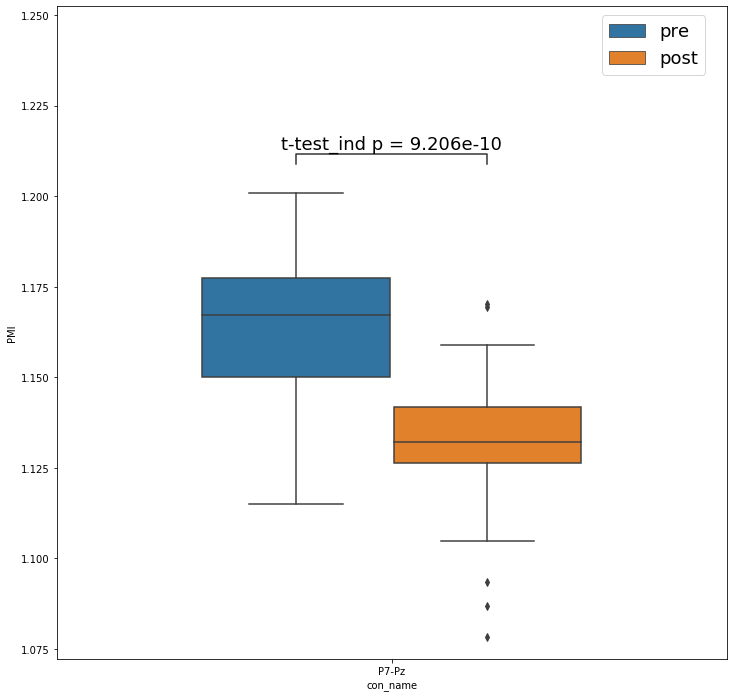

In [175]:
from statannot import add_stat_annotation
fig,ax = plt.subplots(figsize=(12, 12))
ch1_idx = 0
ch2_idx = 3
if diff_cons_mask[ch1_idx][ch2_idx] != 0: # significant diff
    ch1_name = get_ch_name(epochs_hybrid,ch1_idx)
    ch2_name = get_ch_name(epochs_hybrid,ch2_idx)
    con_name = [ch1_name +'-'+ ch2_name]*(PMI_preTMS.shape[0]+PMI_postTMS.shape[0])
    PMI = np.concatenate((PMI_preTMS[:,ch1_idx,ch2_idx],PMI_postTMS[:,ch1_idx,ch2_idx]))
    order = np.concatenate((np.array(['pre']*PMI_preTMS.shape[0]),np.array(['post']*PMI_postTMS.shape[0])))
    data = {'con_name':con_name,'PMI':PMI,'order':order}
    df = pd.DataFrame(data, columns = ['con_name','PMI','order'])
    x = 'con_name'
    y = 'PMI'
    hue = 'order'
    ax = sns.boxplot(data=df, x=x, y=y, hue=hue,ax=ax)
    add_stat_annotation(ax,data=df, x=x, y=y, 
                        box_pairs=[((con_name[0],"pre"),(con_name[0],"post"))],
                        hue=hue,test='t-test_ind',text_format='full',fontsize=18,verbose=1)
    plt.legend(loc='upper left', bbox_to_anchor = (0.8,1),prop={'size': 18})
    diff_prePost_bp_fName = os.path.join(global_results_dir,ch1_name+'_'+ch2_name+'_prePost_bp.eps')
#     plt.cla()

In [164]:
p_values[0]
t_stats[0]

array([  0.        ,  12.82812555,   1.95606976,   6.85940451,
        21.47319453,   5.45356695,  14.43592723,  40.24158722,
       -14.84363836,  -4.87590958,   2.61184757,  11.45178133,
         2.63028716,  -0.06867446,  -6.21503615,  -4.38357574,
        13.21148394,  -6.98622043,  -1.50894387,  22.80754617,
        20.89809732, -14.64120317,   7.32126807,  -2.18169006,
         9.85465652,  -5.4442684 ,   9.0378935 ,  -8.35604544,
        -7.23885951,  -7.35807689,  -3.25587197,  11.22956137,
       -10.19293112, -14.0212426 ,   3.59701031,   4.99648621,
        -1.07633307,   5.38107658,   5.50765342,  -3.55040248])

In [116]:
######## import #########
import seaborn as sns
import matplotlib.pyplot as plt
#########################

########## Customization ##########

embdim = 3
embdelay = 1

###################################
# epoch = df_hybrid[df_hybrid['epoch']==0].to_numpy()[:,3:].T

PMI_preTMS = PMI_epochs(epoch_data_preTMS,embdim,embdelay)
PMI_postTMS = PMI_epochs(epoch_data_postTMS,embdim,embdelay)

for PMI_idx in PMI.shape[0]:
    PMI[PMI_idx] = chs_remap(PMI[PMI_idx],epochs_hybrid.info['ch_names'],affected_h)

for PMI_idx in PMI.shape[0]:
    PMI[PMI_idx] = chs_remap(PMI[PMI_idx],epochs_hybrid.info['ch_names'],affected_h)

PMI_preTMS_withoutD = PMI_preTMS.copy()
PMI_postTMS_withoutD = PMI_postTMS.copy()
for PMI_idx in range(PMI_preTMS_withoutD.shape[0]):
    PMI_preTMS_withoutD[PMI_idx] = PMI_preTMS_withoutD[PMI_idx] - np.diag(np.diag(PMI_preTMS_withoutD[PMI_idx]))
    PMI_postTMS_withoutD[PMI_idx] = PMI_postTMS_withoutD[PMI_idx] - np.diag(np.diag(PMI_postTMS_withoutD[PMI_idx]))

    